<a href="https://colab.research.google.com/github/Raj10Gupta/A2A--Codes/blob/main/Feature110images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [2]:
import cv2


In [3]:
!pip install torchsummary

In [4]:
import numpy as np

import scipy.io
import os
from numpy.linalg import norm,det,inv,svd
from scipy.linalg import rq
import math
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage,spatial
from tqdm.notebook import trange,tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets,models,transforms
from  torch.utils.data import Dataset,DataLoader,ConcatDataset
from skimage import io,transform,data
from torchvision import transforms,utils
import  os
import sklearn.svm
import cv2
from os.path import exists
import pandas as pd
import PIL
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm,tqdm_notebook
from functools import partial
from  torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
class Image:
    def __init__(self,img,position):
        self.img = img
        self.position  = position
        
inliner_matchset = []
def features_matching(a,keypointlength,threshold):
    bestmatch = np.empty((keypointlength), dtype=np.int16)
    img1index = np.empty((keypointlength),dtype=np.init16)
    distance = np.empty((keypointlength))
    index =0
    for j in range(0,keypointlength):
        x=a[j]
        listx = x.tolist()
        x.sort()
        minval1=x[0]
        minval2=x[1]
        itemindex1 = listx.index(minval1)
        itemindex2 = listx.index(minval2)
        ratio = minval1/minval2
            
        if ratio < threshold:
            bestmatch[index] = itemindex1
            distance[index] = minval1
            img1index[index] = j
            index = index + 1
    return [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
    
def compute_Hmography(im1_pts,im2_pts):
    num_matches=len(im1_pts)
    num_rows = 2*num_matches
    num_cols = 9
    A_matrix_shape = (num_rows,num_cols)
    A = np.zeros(A_matrix_shape)
    a_index = 0
    for i in range(0,num_matches):
        (a_x,a_y) = im1_pts[i]
        (b_x,b_y) = im2_pts[i]
        row1 = [a_x,a_y,1,0,0,0,-b_x*a_x,-b_x*a_y,-b_x]
        row2 = [0,0,0,a_x,a_y,1,-b_y*a_x,-b_y*a_y,-b_y]
        A[a_index] = row1
    
        A[a_index+1] = row2
        a_index += 2
            
    U,s,Vt = np.linalg.svd(A)
    H = np.eye(3)
    H = Vt[-1].reshape(3,3)
    return H
    
def displayplot(img,title):
    plt.figure(figsize=(15,15))
    plt.title(title)
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
        
def RANSAC_alg(f1,f2,matches,nRANSAC,RANSACthresh):
    minMatches = 4
    nBest = 0
    best_inliners = []
    H_estimate = np.eye(3,3)
    global inliner_matchset
    inliner_matchset = []
    for iteration in range(nRANSAC):
        matchSimple = random.sample(matches,minMatches)
        im1_pts = np.empty((minMatches,2))
        im2_pts = np.empty((minMatches,2))
        for i in range(0,minMatches):
            m  = matchSimple[i]
            im1_pts[i] = f1[m.queryIdx].pt
            im2_pts[i] = f2[m.trainIdx].pt
                
        H_estimate = compute_Hmography(im1_pts,im2_pts)
        inliners = get_inliners(f1,f2,matches,H_estimate,RANSACthresh)
        if len(inliners) > nBest:
            nBest = len(inliners)
            best_inliners= inliners
                
    print("Number of best inliners", len(best_inliners))
    for i in range(len(best_inliners)):
        inliner_matchset.append(matches[best_inliners[i]])
    im1_pts = np.empty((len(best_inliners),2))
    im2_pts = np.empty((len(best_inliners),2))
    for i in range(0,len(best_inliners)):
        m = inliner_matchset[i]
        im1_pts[i] = f1[m.queryIdx].pt
        im2_pts[i] = f2[m.trainIdx].pt
    M = compute_Hmography(im1_pts,im2_pts)
    return M, len(best_inliners)
    

    

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raj10gupta","key":"a1dbce9c28d5ee4f04d872da3e225780"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d raj10gupta/uni-campus-dataset

100% 4.33G/4.34G [01:25<00:00, 20.5MB/s]
100% 4.34G/4.34G [01:25<00:00, 54.2MB/s]


In [10]:
from zipfile import ZipFile
file_name = 'uni-campus-dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
files_all = os.listdir('/content/RGB-img/img/')
files_all.sort()

folder_path = '/content/RGB-img/img/'
left_files_path_rev = []
right_files_path = []
for file in files_all[:51]:
    left_files_path_rev.append(folder_path + file)
    
    
left_files_path = left_files_path_rev[::-1]


for file in files_all[51:110]:
    right_files_path.append(folder_path + file)

In [7]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
images_left_bgr = []
images_right_bgr = []
images_left = []
images_right = []


for file in tqdm(left_files_path):
    left_image_sat= cv2.imread(file)
    lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
    lab[...,0] = clahe.apply(lab[...,0])
    left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
    images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
    right_image_sat= cv2.imread(file)
    lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
    lab[...,0] = clahe.apply(lab[...,0])
    right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
    images_right_bgr.append(right_img)


100%|██████████| 59/59 [00:57<00:00,  1.02it/s]


In [8]:
images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []

for file in tqdm(left_files_path):
    left_image_sat= cv2.imread(file)
    left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_left_bgr_no_enhance.append(left_img)

for file in tqdm(right_files_path):
    right_image_sat= cv2.imread(file)
    right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
    images_right_bgr_no_enhance.append(right_img)

100%|██████████| 59/59 [00:20<00:00,  2.83it/s]


In [9]:
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
orb = cv2.ORB_create(5000)
keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for imgs in tqdm(images_left_bgr):
    kpt = orb.detect(imgs,None)
    kpt,descrip = orb.compute(imgs, kpt)
    keypoints_all_left_orb.append(kpt)
    descriptors_all_left_orb.append(descrip)
    points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = orb.detect(imgs,None)
    kpt,descrip = orb.compute(imgs, kpt)
    keypoints_all_right_orb.append(kpt)
    descriptors_all_right_orb.append(descrip)
    points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [00:09<00:00,  6.07it/s]


In [11]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

fatal: destination path 'SuperPointPretrainedNetwork' already exists and is not an empty directory.


In [12]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'
cuda = 'True'

In [13]:
def to_kpts(pts,size=1):
    return [cv2.KeyPoint(pt[0],pt[1],size) for pt in pts]

In [14]:
torch.cuda.empty_cache()
class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet,self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1,c2,c3,c4,c5,d1 = 64,64,128,128,256,256
        self.conv1a = nn.Conv2d(1,c1,kernel_size=3,stride=1,padding=1)
        self.conv1b = nn.Conv2d(c1,c1,kernel_size=3,stride=1,padding=1)
        self.conv2a = nn.Conv2d(c1,c2,kernel_size=3,stride=1,padding=1)
        self.conv2b = nn.Conv2d(c2,c2,kernel_size=3,stride=1,padding=1)
        self.conv3a = nn.Conv2d(c2,c3,kernel_size=3,stride=1,padding=1)
        self.conv3b = nn.Conv2d(c3,c3,kernel_size=3,stride=1,padding=1)
        self.conv4a = nn.Conv2d(c3,c4,kernel_size=3,stride=1,padding=1)
        self.conv4b = nn.Conv2d(c4,c4,kernel_size=3,stride=1,padding=1)
        self.convPa = nn.Conv2d(c4,c5,kernel_size=3,stride=1,padding=1)
        self.convPb = nn.Conv2d(c5,65,kernel_size=1,stride=1,padding=0)
        self.convDa = nn.Conv2d(c4,c5,kernel_size=3,stride=1,padding=1)
        
        
        self.convDb = nn.Conv2d(c5,d1,kernel_size=1,stride=1,padding=0)
        
    def forward(self,x):
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x  = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc,p=2,dim=1)
        desc = desc.div(torch.unsqueeze(dn,1))
        return semi,desc
    
    
class SuperPointFrontend(object):
    def __init__(self,weights_path,nms_dist,conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh
        self.cell = 8
        self.border_remove = 4
        
        self.net = SuperPointNet()
        if cuda:
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
            self.net.load_state_dict(torch.load(weights_path,map_location=lambda storage, loc: storage))
        self.net.eval()
        
    def nms_fast(self,in_corners,H,W,dist_thresh):
        grid = np.zeros((H,W)).astype(int)
        inds = np.zeros((H,W)).astype(int)
        inds1 = np.argsort(-in_corners[2,:])
        corners  = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int)
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out =  np.vstack((rcorners,in_corners[2])).reshape(3,1)
            return out,np.zeros((1)).astype(int)
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i],rcorners[0,i]] =1
            inds[rcorners[1,i],rcorners[0,i]] =i
        pad = dist_thresh
        grid = np.pad(grid,((pad,pad),(pad,pad)),mode='constant')
        count = 0
        for i,rc  in enumerate(rcorners.T):
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1:
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1]=0
                
                
                grid[pt[1], pt[0]] = -1
                count += 1
                
        keepy, keepx = np.where(grid==-1)
        keepy,keepx = keepy-pad , keepx-pad
        inds_keep = inds[keepy, keepx]
        out  = corners[:,inds_keep]
        values = out[-1,:]
        inds2 = np.argsort(-values)
        out = out[:,inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds
    
    def run(self,img):
        assert img.ndim == 2
        assert img.dtype == np.float32
        H,W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1,H,W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1,1,H,W)
        if self.cuda:
            inp = inp.cuda()
        outs = self.net.forward(inp)
        semi,coarse_desc = outs[0],outs[1]
        semi = semi.data.cpu().numpy().squeeze()
        
        
        dense = np.exp(semi)
        dense = dense / (np.sum(dense,axis=0)+.00001)
        nodust = dense[:-1,:,:]
        Hc = int(H / self.cell)
        Wc = int(W  / self.cell)
        nodust = np.transpose(nodust,[1,2,0])
        heatmap = np.reshape(nodust,[Hc,Wc,self.cell,self.cell])
        heatmap = np.transpose(heatmap,[0,2,1,3])
        heatmap = np.reshape(heatmap,[Hc*self.cell, Wc*self.cell])
        prob_map  = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap,coarse_desc
    
    def key_pt_sampling(self,img,heat_map,coarse_desc,sampled):
        H,W = img.shape[0], img.shape[1]
        xs,ys = np.where(heat_map >= self.conf_thresh)
        if len(xs) == 0:
            return np.zeros((3,0)),None,None
        print("Number of pts selected:",len(xs))
        
        pts = np.zeros((3,len(xs)))
        pts[0,:] = ys
        pts[1,:] = xs
        pts[2,:] = heat_map[xs,ys]
        pts,_ = self.nms_fast(pts,H,W,dist_thresh=self.nms_dist)
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]]
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0,:] < bord, pts[0,:] >= (W-bord))
        toremoveH = np.logical_or(pts[1,:] < bord, pts[0,:] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:,~toremove]
        pts = pts[:,0:sampled]
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D,0))
        else:
            samp_pts = torch.from_numpy(pts[:2,:].copy())
            samp_pts[0,:] = (samp_pts[0,:] / (float(W)/2.))-1.
            samp_pts[1,:] = (samp_pts[1,:] / (float(W)/2.))-1.
            samp_pts = samp_pts.transpose(0,1).contiguous()
            samp_pts = samp_pts.view(1,1,-1,2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D,-1)
            desc /= np.linalg.norm(desc,axis=0)[np.newaxis,:]
        return pts,desc
            
                             
            
                                  
                       

In [ ]:
print('Load pre trained network')
fe = SuperPointFrontend(weights_path = weights_path, nms_dist = 4, conf_thresh  = 0.015, nn_thresh=0.7,
                       cuda = cuda)
print('Successfully  loaded pretrained network')

Load pre trained network


In [ ]:
num_kps_orb = []
for j  in tqdm(keypoints_all_left_orb + keypoints_all_right_orb):
    num_kps_orb.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 101512.31it/s]


In [ ]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)
    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,matched_pts2,cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [ ]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    lff1 = np.float32(descripts[0])
    lff = np.float32(descripts[1])
    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe’s ratio test)
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            
            matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio",len(matches_4))
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matche_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matche_idx])
    
    '''
    # Estimate homography 1
    #Compute H1
    # Estimate homography 1
    #Compute H1
    imm1_pts=np.empty((len(matches_4),2))
    imm2_pts=np.empty((len(matches_4),2))
    for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)
    H=compute_Homography(imm1_pts,imm2_pts)
    #Robustly estimate Homography 1 using RANSAC
    Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4, nRANSAC=1000, RANSACthresh=6)
    '''
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)

    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches",len(inlier_matchset))
    print("\n")
    '''
    if len(inlier_matchset)<50:
        matches_4 = []
        ratio = 0.67
        # loop over the raw matches
        for m in matches_lf1_lf:
           # ensure the distance is within a certain ratio of each
           # other (i.e. Lowe’s ratio test)
           if len(m) == 2 and m[0].distance < m[1].distance * ratio:
           #matches_1.append((m[0].trainIdx, m[0].queryIdx))
           matches_4.append(m[0])
        print("Number of matches After Lowe's Ratio New",len(matches_4))
        matches_idx = np.array([m.queryIdx for m in matches_4])
        imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
        matches_idx = np.array([m.trainIdx for m in matches_4])
        imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
        Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
        inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
        print("Number of Robust matches New",len(inlier_matchset))
        print("\n")
       '''
    #H=compute_Homography(imm1_pts,imm2_pts)
    #Robustly estimate Homography 1 using RANSAC
    #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4, nRANSAC=1500, RANSACthresh=6)
    #global inlier_matchset
    if disp==True:
        dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
        displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
    return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

    

In [ ]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1])
    H_left_orb.append(H_a)
    num_matches_orb.append(matches)
    num_good_matches_orb.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1])
    H_right_orb.append(H_a)
    num_matches_orb.append(matches)
    num_good_matches_orb.append(gd_matches)    
    

  4%|▍         | 2/51 [00:00<00:08,  5.45it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 253



Number of matches 5000
Number of matches After Lowe's Ratio 373
Number of Robust matches 196




  8%|▊         | 4/51 [00:00<00:08,  5.56it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 391
Number of Robust matches 254



Number of matches 5000
Number of matches After Lowe's Ratio 465
Number of Robust matches 357




 12%|█▏        | 6/51 [00:01<00:08,  5.48it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 377
Number of Robust matches 263



Number of matches 5000
Number of matches After Lowe's Ratio 507
Number of Robust matches 373




 16%|█▌        | 8/51 [00:01<00:07,  5.57it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 432
Number of Robust matches 282



Number of matches 5000
Number of matches After Lowe's Ratio 472
Number of Robust matches 330




 20%|█▉        | 10/51 [00:01<00:07,  5.60it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 568
Number of Robust matches 382



Number of matches 5000
Number of matches After Lowe's Ratio 436
Number of Robust matches 256




 24%|██▎       | 12/51 [00:02<00:08,  4.84it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 320
Number of Robust matches 163



Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 246




 27%|██▋       | 14/51 [00:02<00:07,  5.12it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 400
Number of Robust matches 214



Number of matches 5000
Number of matches After Lowe's Ratio 337
Number of Robust matches 202




 31%|███▏      | 16/51 [00:03<00:06,  5.29it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 335
Number of Robust matches 186



Number of matches 5000
Number of matches After Lowe's Ratio 345
Number of Robust matches 147




 35%|███▌      | 18/51 [00:03<00:06,  5.32it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 395
Number of Robust matches 216



Number of matches 5000
Number of matches After Lowe's Ratio 329
Number of Robust matches 157




 37%|███▋      | 19/51 [00:03<00:06,  5.30it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 275
Number of Robust matches 96



Number of matches 5000
Number of matches After Lowe's Ratio 293


 39%|███▉      | 20/51 [00:03<00:05,  5.27it/s]

Number of Robust matches 101



Number of matches 5000
Number of matches After Lowe's Ratio 190


 41%|████      | 21/51 [00:04<00:06,  4.96it/s]

Number of Robust matches 45



Number of matches 5000
Number of matches After Lowe's Ratio 153


 45%|████▌     | 23/51 [00:04<00:05,  4.90it/s]

Number of Robust matches 11



Number of matches 5000
Number of matches After Lowe's Ratio 342
Number of Robust matches 144




 49%|████▉     | 25/51 [00:04<00:04,  5.22it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 418
Number of Robust matches 195



Number of matches 5000
Number of matches After Lowe's Ratio 319
Number of Robust matches 139




 51%|█████     | 26/51 [00:04<00:04,  5.23it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 297
Number of Robust matches 129



Number of matches 5000
Number of matches After Lowe's Ratio 273


 53%|█████▎    | 27/51 [00:05<00:04,  5.08it/s]

Number of Robust matches 70



Number of matches 5000
Number of matches After Lowe's Ratio 342


 57%|█████▋    | 29/51 [00:05<00:04,  4.95it/s]

Number of Robust matches 71



Number of matches 5000
Number of matches After Lowe's Ratio 263
Number of Robust matches 68




 61%|██████    | 31/51 [00:05<00:03,  5.26it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 324
Number of Robust matches 177



Number of matches 5000
Number of matches After Lowe's Ratio 402
Number of Robust matches 246




 65%|██████▍   | 33/51 [00:06<00:03,  5.43it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 514
Number of Robust matches 343



Number of matches 5000
Number of matches After Lowe's Ratio 520
Number of Robust matches 374




 69%|██████▊   | 35/51 [00:06<00:02,  5.58it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 497
Number of Robust matches 310



Number of matches 5000
Number of matches After Lowe's Ratio 489
Number of Robust matches 300




 73%|███████▎  | 37/51 [00:07<00:02,  5.56it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 420
Number of Robust matches 234



Number of matches 5000
Number of matches After Lowe's Ratio 336
Number of Robust matches 162




 76%|███████▋  | 39/51 [00:07<00:02,  5.58it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 307
Number of Robust matches 142



Number of matches 5000
Number of matches After Lowe's Ratio 572
Number of Robust matches 423




 80%|████████  | 41/51 [00:07<00:01,  5.63it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 521
Number of Robust matches 389



Number of matches 5000
Number of matches After Lowe's Ratio 333
Number of Robust matches 202




 84%|████████▍ | 43/51 [00:08<00:01,  5.02it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 340
Number of Robust matches 181



Number of matches 5000
Number of matches After Lowe's Ratio 442
Number of Robust matches 269




 88%|████████▊ | 45/51 [00:08<00:01,  5.32it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 312
Number of Robust matches 181



Number of matches 5000
Number of matches After Lowe's Ratio 368
Number of Robust matches 200




 92%|█████████▏| 47/51 [00:08<00:00,  5.41it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 356
Number of Robust matches 155



Number of matches 5000
Number of matches After Lowe's Ratio 392
Number of Robust matches 156




 94%|█████████▍| 48/51 [00:09<00:00,  5.24it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 318
Number of Robust matches 94



Number of matches 5000
Number of matches After Lowe's Ratio 413


 96%|█████████▌| 49/51 [00:09<00:00,  5.28it/s]

Number of Robust matches 143



Number of matches 5000
Number of matches After Lowe's Ratio 196


  2%|▏         | 1/59 [00:00<00:10,  5.43it/s]

Number of Robust matches 22



Number of matches 5000
Number of matches After Lowe's Ratio 373
Number of Robust matches 233




  5%|▌         | 3/59 [00:00<00:10,  5.55it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 242
Number of Robust matches 97



Number of matches 5000
Number of matches After Lowe's Ratio 353
Number of Robust matches 197




  8%|▊         | 5/59 [00:00<00:09,  5.51it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 379
Number of Robust matches 166



Number of matches 5000
Number of matches After Lowe's Ratio 394
Number of Robust matches 202




 10%|█         | 6/59 [00:01<00:09,  5.52it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 373
Number of Robust matches 180



Number of matches 5000
Number of matches After Lowe's Ratio 147


 12%|█▏        | 7/59 [00:01<00:10,  5.16it/s]

Number of Robust matches 6



Number of matches 5000
Number of matches After Lowe's Ratio 206


 14%|█▎        | 8/59 [00:01<00:10,  4.94it/s]

Number of Robust matches 30



Number of matches 5000
Number of matches After Lowe's Ratio 175


 17%|█▋        | 10/59 [00:01<00:09,  4.96it/s]

Number of Robust matches 38



Number of matches 5000
Number of matches After Lowe's Ratio 301
Number of Robust matches 137




 20%|██        | 12/59 [00:02<00:08,  5.29it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 507
Number of Robust matches 331



Number of matches 5000
Number of matches After Lowe's Ratio 501
Number of Robust matches 327




 22%|██▏       | 13/59 [00:02<00:08,  5.36it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 331
Number of Robust matches 194



Number of matches 5000
Number of matches After Lowe's Ratio 221


 25%|██▌       | 15/59 [00:02<00:08,  5.39it/s]

Number of Robust matches 64



Number of matches 5000
Number of matches After Lowe's Ratio 432
Number of Robust matches 300




 29%|██▉       | 17/59 [00:03<00:07,  5.39it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 301
Number of Robust matches 151



Number of matches 5000
Number of matches After Lowe's Ratio 535
Number of Robust matches 386




 32%|███▏      | 19/59 [00:03<00:07,  5.56it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 630
Number of Robust matches 491



Number of matches 5000
Number of matches After Lowe's Ratio 388
Number of Robust matches 267




 36%|███▌      | 21/59 [00:03<00:06,  5.60it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 497
Number of Robust matches 363



Number of matches 5000
Number of matches After Lowe's Ratio 352
Number of Robust matches 210




 37%|███▋      | 22/59 [00:04<00:06,  5.54it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 495
Number of Robust matches 320




 41%|████      | 24/59 [00:04<00:06,  5.10it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 429
Number of Robust matches 246



Number of matches 5000
Number of matches After Lowe's Ratio 462
Number of Robust matches 283




 44%|████▍     | 26/59 [00:04<00:06,  5.35it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 403
Number of Robust matches 252



Number of matches 5000
Number of matches After Lowe's Ratio 359
Number of Robust matches 158




 47%|████▋     | 28/59 [00:05<00:05,  5.43it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 396
Number of Robust matches 167



Number of matches 5000
Number of matches After Lowe's Ratio 412
Number of Robust matches 195




 51%|█████     | 30/59 [00:05<00:05,  5.42it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 437
Number of Robust matches 196



Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 173




 53%|█████▎    | 31/59 [00:05<00:05,  5.48it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 403
Number of Robust matches 225



Number of matches 5000
Number of matches After Lowe's Ratio 124


 54%|█████▍    | 32/59 [00:06<00:05,  5.18it/s]

Number of Robust matches 7



Number of matches 5000
Number of matches After Lowe's Ratio 215


 56%|█████▌    | 33/59 [00:06<00:05,  4.95it/s]

Number of Robust matches 43



Number of matches 5000
Number of matches After Lowe's Ratio 128


 58%|█████▊    | 34/59 [00:06<00:05,  4.79it/s]

Number of Robust matches 6



Number of matches 5000
Number of matches After Lowe's Ratio 230


 61%|██████    | 36/59 [00:06<00:04,  4.99it/s]

Number of Robust matches 57



Number of matches 5000
Number of matches After Lowe's Ratio 389
Number of Robust matches 210




 64%|██████▍   | 38/59 [00:07<00:04,  5.19it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 404
Number of Robust matches 163



Number of matches 5000
Number of matches After Lowe's Ratio 370
Number of Robust matches 160




 66%|██████▌   | 39/59 [00:07<00:03,  5.19it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 303
Number of Robust matches 94



Number of matches 5000
Number of matches After Lowe's Ratio 301


 69%|██████▉   | 41/59 [00:07<00:03,  5.09it/s]

Number of Robust matches 71



Number of matches 5000
Number of matches After Lowe's Ratio 410
Number of Robust matches 165




 73%|███████▎  | 43/59 [00:08<00:03,  5.26it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 245
Number of Robust matches 75



Number of matches 5000
Number of matches After Lowe's Ratio 376
Number of Robust matches 213




 76%|███████▋  | 45/59 [00:08<00:02,  5.38it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 330
Number of Robust matches 124



Number of matches 5000
Number of matches After Lowe's Ratio 307
Number of Robust matches 136




 80%|███████▉  | 47/59 [00:08<00:02,  5.49it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 298
Number of Robust matches 186



Number of matches 5000
Number of matches After Lowe's Ratio 550
Number of Robust matches 355




 83%|████████▎ | 49/59 [00:09<00:01,  5.50it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 417
Number of Robust matches 287



Number of matches 5000
Number of matches After Lowe's Ratio 662
Number of Robust matches 506




 86%|████████▋ | 51/59 [00:09<00:01,  5.52it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 459
Number of Robust matches 280



Number of matches 5000
Number of matches After Lowe's Ratio 598
Number of Robust matches 407




 90%|████████▉ | 53/59 [00:10<00:01,  5.49it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 300
Number of Robust matches 172



Number of matches 5000
Number of matches After Lowe's Ratio 397
Number of Robust matches 233




 93%|█████████▎| 55/59 [00:10<00:00,  5.05it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 365
Number of Robust matches 219



Number of matches 5000
Number of matches After Lowe's Ratio 597
Number of Robust matches 421




 97%|█████████▋| 57/59 [00:10<00:00,  5.20it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 396
Number of Robust matches 258



Number of matches 5000
Number of matches After Lowe's Ratio 541
Number of Robust matches 371




 98%|█████████▊| 58/59 [00:11<00:00,  5.33it/s]


Number of matches 5000
Number of matches After Lowe's Ratio 469
Number of Robust matches 288




# RAM Crashed here after 110 images for orb

In [30]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]

    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht


In [31]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):
    for j,H in enumerate(H_left):
        if j==  0:
            H_trans = Ht@H
            
        else:
            H_trans = H_trans@H
        result =  cv2.warpPerspective(images_left[j+1],H_trans,(xmax-xmin,ymax-ymin))
        warp_img_init_curr = result
        
        if j == 0:
            result[t[1]:h+t[1],t[0]:w+t[0]] = images_left[0]
            warp_img_init_prev = result
            continue
        black_pixels = np.where((warp_img_init_prev[:,:,0]==0)&(warp_img_init_prev[:,:,1]==0)&(warp_img_init_prev[:,:,2]==0))
        warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]
        
    print('step31:Done')
    return warp_img_init_prev
    
def final_step_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):
    for j,H in enumerate(H_right):
        if j==  0:
            H_trans = Ht@H
        else:
            H_trans = H_trans@H
        result =  cv2.warpPerspective(images_right[j+1],H_trans,(xmax-xmin,ymax-ymin))
        warp_img_init_curr = result
        
        
        
        black_pixels = np.where((warp_img_prev[:,:,0]==0)&(warp_img_prev[:,:,1]==0)&(warp_img_prev[:,:,2]==0))
        warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
        
    print('step32:Done')
    return warp_img_prev

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_orb,H_right_orb)


NameError: ignored

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)


In [ ]:
warp_imgs_all_orb = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_orb , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-SIFT')

# ROOTSIFT 110 images

In [ ]:
class RootSIFT:
    def __init__(self):
        # initialize the SIFT feature extractor
        #self.extractor = cv2.DescriptorExtractor_create("SIFT")
        self.sift = cv2.xfeatures2d.SIFT_create()
    def compute(self, image, kps, eps=1e-7):
        # compute SIFT descriptors
        (kps, descs) = self.sift.compute(image, kps)
        # if there are no keypoints or descriptors, return an empty tuple
        if len(kps) == 0:
            return ([], None)
        # apply the Hellinger kernel by first L1-normalizing, taking the
        # square-root, and then L2-normalizing
        descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
        descs /= (descs.sum(axis=0) + eps)
        descs = np.sqrt(descs)
        #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
        # return a tuple of the keypoints and descriptors
        return (kps, descs)

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]
 
keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]
 
for imgs in tqdm(images_left_bgr):
    kpt = sift.detect(imgs,None)
    kpt,descrip = rootsift.compute(imgs, kpt)
    keypoints_all_left_rootsift.append(kpt)
    descriptors_all_left_rootsift.append(descrip)
    points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
for imgs in tqdm(images_right_bgr):
    kpt = sift.detect(imgs,None)
    kpt,descrip = rootsift.compute(imgs, kpt)
    keypoints_all_right_rootsift.append(kpt)
    descriptors_all_right_rootsift.append(descrip)
    points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

NameError: ignored

In [ ]:
num_kps_rootsift = []
for j  in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift):
    num_kps_rootsift.append(len(j))

In [ ]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1])
    H_left_rootsift.append(H_a)
    num_matches_rootsift.append(matches)
    num_good_matches_rootsift.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1])
    H_right_rootsift.append(H_a)
    num_matches_rootsift.append(matches)
    num_good_matches_rootsift.append(gd_matches) 

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_rootsift,H_right_rootsift)


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_rootsift = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_rootsift , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-ROOTSIFT')

# For BRISK 110 image

In [ ]:
Threshl=60;
Octaves=8;
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]


keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]


for imgs in tqdm(images_left_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = brisk.compute(imgs, kpt)
    keypoints_all_left_brisk.append(kpt)
    descriptors_all_left_brisk.append(descrip)
    points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
    kpt = brisk.detect(imgs,None)
    kpt,descrip = brisk.compute(imgs, kpt)
    keypoints_all_right_brisk.append(kpt)
    descriptors_all_right_brisk.append(descrip)
    points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [00:49<00:00,  1.20it/s]


In [ ]:
num_kps_brisk = []
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk):
    num_kps_brisk.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 327912.89it/s]


In [ ]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1])
    H_left_brisk.append(H_a)
    num_matches_brisk.append(matches)
    num_good_matches_brisk.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1])
    H_right_brisk.append(H_a)
    num_matches_brisk.append(matches)
    num_good_matches_brisk.append(gd_matches) 

  2%|▏         | 1/51 [00:02<02:22,  2.85s/it]


Number of matches 32653
Number of matches After Lowe's Ratio 2170
Number of Robust matches 1357




  4%|▍         | 2/51 [00:05<02:23,  2.94s/it]


Number of matches 32146
Number of matches After Lowe's Ratio 2338
Number of Robust matches 1561




  6%|▌         | 3/51 [00:09<02:25,  3.04s/it]


Number of matches 37734
Number of matches After Lowe's Ratio 2467
Number of Robust matches 1622




  8%|▊         | 4/51 [00:13<02:36,  3.33s/it]


Number of matches 37547
Number of matches After Lowe's Ratio 3491
Number of Robust matches 2593




 10%|▉         | 5/51 [00:17<02:39,  3.46s/it]


Number of matches 34839
Number of matches After Lowe's Ratio 2751
Number of Robust matches 2054




 12%|█▏        | 6/51 [00:20<02:34,  3.42s/it]


Number of matches 30911
Number of matches After Lowe's Ratio 2663
Number of Robust matches 2050




 14%|█▎        | 7/51 [00:23<02:26,  3.32s/it]


Number of matches 32047
Number of matches After Lowe's Ratio 2557
Number of Robust matches 1907




 16%|█▌        | 8/51 [00:26<02:21,  3.30s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 2974
Number of Robust matches 2181




 18%|█▊        | 9/51 [00:30<02:19,  3.32s/it]


Number of matches 31280
Number of matches After Lowe's Ratio 3160
Number of Robust matches 2459




 20%|█▉        | 10/51 [00:33<02:13,  3.25s/it]


Number of matches 31427
Number of matches After Lowe's Ratio 2378
Number of Robust matches 1731




 22%|██▏       | 11/51 [00:36<02:08,  3.20s/it]


Number of matches 32135
Number of matches After Lowe's Ratio 1942
Number of Robust matches 1129




 24%|██▎       | 12/51 [00:39<02:05,  3.22s/it]


Number of matches 31815
Number of matches After Lowe's Ratio 2119
Number of Robust matches 1332




 25%|██▌       | 13/51 [00:42<02:01,  3.19s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 2309
Number of Robust matches 1307




 27%|██▋       | 14/51 [00:46<02:00,  3.25s/it]


Number of matches 35870
Number of matches After Lowe's Ratio 1915
Number of Robust matches 1176




 29%|██▉       | 15/51 [00:50<02:07,  3.54s/it]


Number of matches 43958
Number of matches After Lowe's Ratio 2227
Number of Robust matches 879




 31%|███▏      | 16/51 [00:55<02:19,  3.98s/it]


Number of matches 37987
Number of matches After Lowe's Ratio 1862
Number of Robust matches 861




 33%|███▎      | 17/51 [00:59<02:15,  3.99s/it]


Number of matches 32058
Number of matches After Lowe's Ratio 1766
Number of Robust matches 951




 35%|███▌      | 18/51 [01:02<02:02,  3.72s/it]


Number of matches 30297
Number of matches After Lowe's Ratio 1548
Number of Robust matches 577




 37%|███▋      | 19/51 [01:05<01:52,  3.52s/it]


Number of matches 33725
Number of matches After Lowe's Ratio 1002
Number of Robust matches 392




 39%|███▉      | 20/51 [01:08<01:49,  3.53s/it]


Number of matches 34224
Number of matches After Lowe's Ratio 1413
Number of Robust matches 551




 41%|████      | 21/51 [01:12<01:45,  3.50s/it]


Number of matches 34530
Number of matches After Lowe's Ratio 689
Number of Robust matches 246




 43%|████▎     | 22/51 [01:15<01:39,  3.43s/it]


Number of matches 24599
Number of matches After Lowe's Ratio 389
Number of Robust matches 44




 45%|████▌     | 23/51 [01:17<01:26,  3.09s/it]


Number of matches 24704
Number of matches After Lowe's Ratio 1398
Number of Robust matches 666




 47%|████▋     | 24/51 [01:20<01:15,  2.79s/it]


Number of matches 21196
Number of matches After Lowe's Ratio 1365
Number of Robust matches 681




 49%|████▉     | 25/51 [01:21<01:05,  2.54s/it]


Number of matches 26252
Number of matches After Lowe's Ratio 1327
Number of Robust matches 653




 51%|█████     | 26/51 [01:24<01:03,  2.54s/it]


Number of matches 32005
Number of matches After Lowe's Ratio 1718
Number of Robust matches 752




 53%|█████▎    | 27/51 [01:28<01:08,  2.86s/it]


Number of matches 44696
Number of matches After Lowe's Ratio 1773
Number of Robust matches 647




 55%|█████▍    | 28/51 [01:34<01:29,  3.91s/it]


Number of matches 48468
Number of matches After Lowe's Ratio 2358
Number of Robust matches 686




 57%|█████▋    | 29/51 [01:41<01:43,  4.69s/it]


Number of matches 44596
Number of matches After Lowe's Ratio 2135
Number of Robust matches 740




 59%|█████▉    | 30/51 [01:46<01:42,  4.89s/it]


Number of matches 35503
Number of matches After Lowe's Ratio 2129
Number of Robust matches 1063




 61%|██████    | 31/51 [01:50<01:30,  4.55s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 2527
Number of Robust matches 1351




 63%|██████▎   | 32/51 [01:53<01:18,  4.13s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 2557
Number of Robust matches 1738




 65%|██████▍   | 33/51 [01:56<01:08,  3.78s/it]


Number of matches 30511
Number of matches After Lowe's Ratio 2757
Number of Robust matches 1782




 67%|██████▋   | 34/51 [01:59<01:02,  3.66s/it]


Number of matches 36828
Number of matches After Lowe's Ratio 2533
Number of Robust matches 1471




 69%|██████▊   | 35/51 [02:03<01:00,  3.80s/it]


Number of matches 39748
Number of matches After Lowe's Ratio 2999
Number of Robust matches 1708




 71%|███████   | 36/51 [02:08<00:59,  3.99s/it]


Number of matches 38033
Number of matches After Lowe's Ratio 3085
Number of Robust matches 1605




 73%|███████▎  | 37/51 [02:12<00:57,  4.08s/it]


Number of matches 39826
Number of matches After Lowe's Ratio 3011
Number of Robust matches 1598




 75%|███████▍  | 38/51 [02:18<01:01,  4.74s/it]


Number of matches 33296
Number of matches After Lowe's Ratio 2040
Number of Robust matches 1265




 76%|███████▋  | 39/51 [02:22<00:52,  4.38s/it]


Number of matches 31758
Number of matches After Lowe's Ratio 3403
Number of Robust matches 2336




 78%|███████▊  | 40/51 [02:25<00:44,  4.04s/it]


Number of matches 31028
Number of matches After Lowe's Ratio 3026
Number of Robust matches 2146




 80%|████████  | 41/51 [02:28<00:36,  3.69s/it]


Number of matches 27881
Number of matches After Lowe's Ratio 1762
Number of Robust matches 1120




 82%|████████▏ | 42/51 [02:31<00:30,  3.37s/it]


Number of matches 27362
Number of matches After Lowe's Ratio 1664
Number of Robust matches 1048




 84%|████████▍ | 43/51 [02:33<00:24,  3.10s/it]


Number of matches 27680
Number of matches After Lowe's Ratio 2330
Number of Robust matches 1713




 86%|████████▋ | 44/51 [02:36<00:20,  2.97s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 2206
Number of Robust matches 1174




 88%|████████▊ | 45/51 [02:39<00:18,  3.05s/it]


Number of matches 27042
Number of matches After Lowe's Ratio 2064
Number of Robust matches 1476




 90%|█████████ | 46/51 [02:41<00:14,  2.90s/it]


Number of matches 29160
Number of matches After Lowe's Ratio 1890
Number of Robust matches 848




 92%|█████████▏| 47/51 [02:44<00:11,  2.88s/it]


Number of matches 32830
Number of matches After Lowe's Ratio 2771
Number of Robust matches 1328




 94%|█████████▍| 48/51 [02:48<00:09,  3.11s/it]


Number of matches 33004
Number of matches After Lowe's Ratio 1826
Number of Robust matches 691




 96%|█████████▌| 49/51 [02:52<00:06,  3.30s/it]


Number of matches 35929
Number of matches After Lowe's Ratio 2738
Number of Robust matches 1059




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 25316
Number of matches After Lowe's Ratio 839
Number of Robust matches 238




  2%|▏         | 1/59 [00:02<02:50,  2.94s/it]


Number of matches 22854
Number of matches After Lowe's Ratio 1641
Number of Robust matches 961




  3%|▎         | 2/59 [00:05<02:36,  2.74s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 1298
Number of Robust matches 570




  5%|▌         | 3/59 [00:08<02:38,  2.83s/it]


Number of matches 26534
Number of matches After Lowe's Ratio 1956
Number of Robust matches 872




  7%|▋         | 4/59 [00:10<02:32,  2.78s/it]


Number of matches 28302
Number of matches After Lowe's Ratio 1863
Number of Robust matches 913




  8%|▊         | 5/59 [00:13<02:27,  2.73s/it]


Number of matches 23435
Number of matches After Lowe's Ratio 1757
Number of Robust matches 1046




 10%|█         | 6/59 [00:15<02:15,  2.55s/it]


Number of matches 26028
Number of matches After Lowe's Ratio 1633
Number of Robust matches 765




 12%|█▏        | 7/59 [00:18<02:13,  2.57s/it]


Number of matches 30921
Number of matches After Lowe's Ratio 534
Number of Robust matches 11




 14%|█▎        | 8/59 [00:21<02:15,  2.66s/it]


Number of matches 25059
Number of matches After Lowe's Ratio 712
Number of Robust matches 240




 15%|█▌        | 9/59 [00:23<02:05,  2.52s/it]


Number of matches 23035
Number of matches After Lowe's Ratio 722
Number of Robust matches 310




 17%|█▋        | 10/59 [00:25<01:55,  2.36s/it]


Number of matches 24778
Number of matches After Lowe's Ratio 904
Number of Robust matches 402




 19%|█▊        | 11/59 [00:28<01:57,  2.46s/it]


Number of matches 35128
Number of matches After Lowe's Ratio 1816
Number of Robust matches 1216




 20%|██        | 12/59 [00:31<02:08,  2.73s/it]


Number of matches 28715
Number of matches After Lowe's Ratio 2213
Number of Robust matches 1584




 22%|██▏       | 13/59 [00:33<02:03,  2.68s/it]


Number of matches 25864
Number of matches After Lowe's Ratio 1205
Number of Robust matches 739




 24%|██▎       | 14/59 [00:36<01:57,  2.60s/it]


Number of matches 24371
Number of matches After Lowe's Ratio 595
Number of Robust matches 253




 25%|██▌       | 15/59 [00:38<01:47,  2.44s/it]


Number of matches 21250
Number of matches After Lowe's Ratio 1599
Number of Robust matches 1084




 27%|██▋       | 16/59 [00:40<01:39,  2.32s/it]


Number of matches 31082
Number of matches After Lowe's Ratio 1103
Number of Robust matches 607




 29%|██▉       | 17/59 [00:43<01:46,  2.54s/it]


Number of matches 31880
Number of matches After Lowe's Ratio 2734
Number of Robust matches 1901




 31%|███       | 18/59 [00:47<01:56,  2.83s/it]


Number of matches 33259
Number of matches After Lowe's Ratio 2985
Number of Robust matches 2417




 32%|███▏      | 19/59 [00:50<01:59,  2.98s/it]


Number of matches 29687
Number of matches After Lowe's Ratio 2424
Number of Robust matches 2032




 34%|███▍      | 20/59 [00:53<02:00,  3.10s/it]


Number of matches 33001
Number of matches After Lowe's Ratio 2445
Number of Robust matches 1709




 36%|███▌      | 21/59 [00:57<02:02,  3.21s/it]


Number of matches 33071
Number of matches After Lowe's Ratio 1853
Number of Robust matches 1322




 37%|███▋      | 22/59 [01:00<02:02,  3.32s/it]


Number of matches 35123
Number of matches After Lowe's Ratio 2208
Number of Robust matches 1511




 39%|███▉      | 23/59 [01:04<02:05,  3.48s/it]


Number of matches 39155
Number of matches After Lowe's Ratio 2279
Number of Robust matches 1444




 41%|████      | 24/59 [01:08<02:09,  3.70s/it]


Number of matches 37668
Number of matches After Lowe's Ratio 2534
Number of Robust matches 1430




 42%|████▏     | 25/59 [01:13<02:17,  4.03s/it]


Number of matches 40615
Number of matches After Lowe's Ratio 2837
Number of Robust matches 1194




 44%|████▍     | 26/59 [01:17<02:15,  4.10s/it]


Number of matches 35723
Number of matches After Lowe's Ratio 2593
Number of Robust matches 1269




 46%|████▌     | 27/59 [01:21<02:05,  3.92s/it]


Number of matches 29133
Number of matches After Lowe's Ratio 1968
Number of Robust matches 908




 47%|████▋     | 28/59 [01:24<01:52,  3.62s/it]


Number of matches 31575
Number of matches After Lowe's Ratio 2590
Number of Robust matches 859




 49%|████▉     | 29/59 [01:27<01:45,  3.52s/it]


Number of matches 30053
Number of matches After Lowe's Ratio 2222
Number of Robust matches 712




 51%|█████     | 30/59 [01:30<01:35,  3.28s/it]


Number of matches 24008
Number of matches After Lowe's Ratio 1563
Number of Robust matches 686




 53%|█████▎    | 31/59 [01:32<01:23,  2.99s/it]


Number of matches 29051
Number of matches After Lowe's Ratio 1383
Number of Robust matches 642




 54%|█████▍    | 32/59 [01:35<01:22,  3.07s/it]


Number of matches 45494
Number of matches After Lowe's Ratio 578
Number of Robust matches 111




 56%|█████▌    | 33/59 [01:41<01:41,  3.92s/it]


Number of matches 41453
Number of matches After Lowe's Ratio 1103
Number of Robust matches 372




 58%|█████▊    | 34/59 [01:47<01:51,  4.47s/it]


Number of matches 47391
Number of matches After Lowe's Ratio 362
Number of Robust matches 5




 59%|█████▉    | 35/59 [01:53<01:55,  4.82s/it]


Number of matches 36711
Number of matches After Lowe's Ratio 1005
Number of Robust matches 319




 61%|██████    | 36/59 [01:57<01:44,  4.54s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 1884
Number of Robust matches 779




 63%|██████▎   | 37/59 [02:00<01:32,  4.19s/it]


Number of matches 32321
Number of matches After Lowe's Ratio 2032
Number of Robust matches 680




 64%|██████▍   | 38/59 [02:03<01:20,  3.83s/it]


Number of matches 28452
Number of matches After Lowe's Ratio 1635
Number of Robust matches 530




 66%|██████▌   | 39/59 [02:06<01:09,  3.48s/it]


Number of matches 26073
Number of matches After Lowe's Ratio 1390
Number of Robust matches 439




 68%|██████▊   | 40/59 [02:08<00:59,  3.13s/it]


Number of matches 27594
Number of matches After Lowe's Ratio 1356
Number of Robust matches 428




 69%|██████▉   | 41/59 [02:11<00:54,  3.01s/it]


Number of matches 29922
Number of matches After Lowe's Ratio 2392
Number of Robust matches 780




 71%|███████   | 42/59 [02:14<00:51,  3.02s/it]


Number of matches 31761
Number of matches After Lowe's Ratio 1460
Number of Robust matches 404




 73%|███████▎  | 43/59 [02:17<00:48,  3.03s/it]


Number of matches 28598
Number of matches After Lowe's Ratio 2069
Number of Robust matches 900




 75%|███████▍  | 44/59 [02:20<00:44,  2.96s/it]


Number of matches 32677
Number of matches After Lowe's Ratio 1941
Number of Robust matches 688




 76%|███████▋  | 45/59 [02:23<00:43,  3.08s/it]


Number of matches 25600
Number of matches After Lowe's Ratio 1482
Number of Robust matches 626




 78%|███████▊  | 46/59 [02:25<00:37,  2.87s/it]


Number of matches 28462
Number of matches After Lowe's Ratio 1087
Number of Robust matches 753




 80%|███████▉  | 47/59 [02:28<00:33,  2.83s/it]


Number of matches 28784
Number of matches After Lowe's Ratio 1396
Number of Robust matches 967




 81%|████████▏ | 48/59 [02:31<00:31,  2.84s/it]


Number of matches 27866
Number of matches After Lowe's Ratio 1431
Number of Robust matches 956




 83%|████████▎ | 49/59 [02:33<00:27,  2.76s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 2258
Number of Robust matches 1588




 85%|████████▍ | 50/59 [02:36<00:23,  2.62s/it]


Number of matches 25632
Number of matches After Lowe's Ratio 1239
Number of Robust matches 697




 86%|████████▋ | 51/59 [02:38<00:20,  2.53s/it]


Number of matches 25983
Number of matches After Lowe's Ratio 2242
Number of Robust matches 1450




 88%|████████▊ | 52/59 [02:40<00:16,  2.38s/it]


Number of matches 13694
Number of matches After Lowe's Ratio 736
Number of Robust matches 422




 90%|████████▉ | 53/59 [02:41<00:11,  1.97s/it]


Number of matches 9250
Number of matches After Lowe's Ratio 1004
Number of Robust matches 578




 92%|█████████▏| 54/59 [02:42<00:07,  1.58s/it]


Number of matches 10843
Number of matches After Lowe's Ratio 598
Number of Robust matches 357




 93%|█████████▎| 55/59 [02:43<00:05,  1.33s/it]


Number of matches 12481
Number of matches After Lowe's Ratio 1368
Number of Robust matches 889




 95%|█████████▍| 56/59 [02:44<00:03,  1.23s/it]


Number of matches 22262
Number of matches After Lowe's Ratio 1268
Number of Robust matches 760




 97%|█████████▋| 57/59 [02:46<00:02,  1.47s/it]


Number of matches 25793
Number of matches After Lowe's Ratio 1895
Number of Robust matches 1288




 98%|█████████▊| 58/59 [02:48<00:01,  1.79s/it]


Number of matches 25355
Number of matches After Lowe's Ratio 2014
Number of Robust matches 1211




In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_brisk,H_right_brisk)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_brisk = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_brisk , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-BRISK')

# For Surf 110 images

In [ ]:
surf = cv2.xfeatures2d.SURF_create()
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]
for imgs in tqdm(images_left_bgr):
    kpt = surf.detect(imgs,None)
    kpt,descrip = surf.compute(imgs, kpt)
    keypoints_all_left_surf.append(kpt)
    descriptors_all_left_surf.append(descrip)
    points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr):
    kpt = surf.detect(imgs,None)
    kpt,descrip = surf.compute(imgs, kpt)
    keypoints_all_right_surf.append(kpt)
    descriptors_all_right_surf.append(descrip)
    points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [07:35<00:00,  7.72s/it]


In [ ]:
num_kps_surf = []
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf):
    num_kps_surf.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 220015.95it/s]


In [ ]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j++2][::-1],descriptors_all_left_surf[j:j+2][::-1])
    H_left_surf.append(H_a)
    num_matches_surf.append(matches)
    num_good_matches_surf.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1])
    H_right_surf.append(H_a)
    num_matches_surf.append(matches)
    num_good_matches_surf.append(gd_matches)    

  2%|▏         | 1/51 [00:03<02:51,  3.42s/it]


Number of matches 34564
Number of matches After Lowe's Ratio 4305
Number of Robust matches 2365




  4%|▍         | 2/51 [00:06<02:47,  3.42s/it]


Number of matches 34700
Number of matches After Lowe's Ratio 3942
Number of Robust matches 2105




  6%|▌         | 3/51 [00:10<02:51,  3.58s/it]


Number of matches 37406
Number of matches After Lowe's Ratio 4528
Number of Robust matches 2272




  8%|▊         | 4/51 [00:14<02:53,  3.69s/it]


Number of matches 38907
Number of matches After Lowe's Ratio 6807
Number of Robust matches 4559




 10%|▉         | 5/51 [00:18<02:56,  3.85s/it]


Number of matches 37650
Number of matches After Lowe's Ratio 6076
Number of Robust matches 3714




 12%|█▏        | 6/51 [00:22<02:54,  3.87s/it]


Number of matches 38049
Number of matches After Lowe's Ratio 5952
Number of Robust matches 3824




 14%|█▎        | 7/51 [00:27<02:54,  3.95s/it]


Number of matches 38270
Number of matches After Lowe's Ratio 6071
Number of Robust matches 4053




 16%|█▌        | 8/51 [00:31<02:51,  3.98s/it]


Number of matches 38222
Number of matches After Lowe's Ratio 6868
Number of Robust matches 4666




 18%|█▊        | 9/51 [00:35<02:49,  4.03s/it]


Number of matches 37766
Number of matches After Lowe's Ratio 7482
Number of Robust matches 5123




 20%|█▉        | 10/51 [00:39<02:44,  4.01s/it]


Number of matches 38678
Number of matches After Lowe's Ratio 6077
Number of Robust matches 3810




 22%|██▏       | 11/51 [00:43<02:41,  4.05s/it]


Number of matches 38137
Number of matches After Lowe's Ratio 4761
Number of Robust matches 2887




 24%|██▎       | 12/51 [00:47<02:35,  3.98s/it]


Number of matches 37525
Number of matches After Lowe's Ratio 5494
Number of Robust matches 3266




 25%|██▌       | 13/51 [00:51<02:30,  3.96s/it]


Number of matches 37759
Number of matches After Lowe's Ratio 4505
Number of Robust matches 2426




 27%|██▋       | 14/51 [00:55<02:26,  3.96s/it]


Number of matches 38066
Number of matches After Lowe's Ratio 4905
Number of Robust matches 2895




 29%|██▉       | 15/51 [00:59<02:24,  4.02s/it]


Number of matches 38808
Number of matches After Lowe's Ratio 2611
Number of Robust matches 970




 31%|███▏      | 16/51 [01:03<02:19,  4.00s/it]


Number of matches 37519
Number of matches After Lowe's Ratio 3045
Number of Robust matches 1237




 33%|███▎      | 17/51 [01:06<02:13,  3.92s/it]


Number of matches 35706
Number of matches After Lowe's Ratio 3938
Number of Robust matches 1816




 35%|███▌      | 18/51 [01:10<02:10,  3.96s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 3282
Number of Robust matches 1162




 37%|███▋      | 19/51 [01:14<02:07,  3.98s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 2088
Number of Robust matches 694




 39%|███▉      | 20/51 [01:18<02:02,  3.95s/it]


Number of matches 37306
Number of matches After Lowe's Ratio 3300
Number of Robust matches 1358




 41%|████      | 21/51 [01:22<01:58,  3.93s/it]


Number of matches 35977
Number of matches After Lowe's Ratio 1965
Number of Robust matches 661




 43%|████▎     | 22/51 [01:26<01:51,  3.86s/it]


Number of matches 35736
Number of matches After Lowe's Ratio 1506
Number of Robust matches 256




 45%|████▌     | 23/51 [01:30<01:47,  3.83s/it]


Number of matches 36312
Number of matches After Lowe's Ratio 4398
Number of Robust matches 2430




 47%|████▋     | 24/51 [01:33<01:42,  3.78s/it]


Number of matches 35698
Number of matches After Lowe's Ratio 4733
Number of Robust matches 2775




 49%|████▉     | 25/51 [01:37<01:38,  3.78s/it]


Number of matches 36283
Number of matches After Lowe's Ratio 4363
Number of Robust matches 2524




 51%|█████     | 26/51 [01:41<01:34,  3.78s/it]


Number of matches 37204
Number of matches After Lowe's Ratio 4886
Number of Robust matches 2603




 53%|█████▎    | 27/51 [01:45<01:34,  3.92s/it]


Number of matches 38737
Number of matches After Lowe's Ratio 4205
Number of Robust matches 2002




 55%|█████▍    | 28/51 [01:49<01:32,  4.00s/it]


Number of matches 40144
Number of matches After Lowe's Ratio 4512
Number of Robust matches 1567




 57%|█████▋    | 29/51 [01:54<01:30,  4.12s/it]


Number of matches 39400
Number of matches After Lowe's Ratio 4116
Number of Robust matches 1725




 59%|█████▉    | 30/51 [01:58<01:27,  4.15s/it]


Number of matches 38368
Number of matches After Lowe's Ratio 5089
Number of Robust matches 2513




 61%|██████    | 31/51 [02:02<01:23,  4.18s/it]


Number of matches 38791
Number of matches After Lowe's Ratio 5948
Number of Robust matches 2992




 63%|██████▎   | 32/51 [02:06<01:18,  4.15s/it]


Number of matches 38100
Number of matches After Lowe's Ratio 6010
Number of Robust matches 3725




 65%|██████▍   | 33/51 [02:10<01:14,  4.15s/it]


Number of matches 39195
Number of matches After Lowe's Ratio 6882
Number of Robust matches 4280




 67%|██████▋   | 34/51 [02:15<01:10,  4.16s/it]


Number of matches 40180
Number of matches After Lowe's Ratio 6296
Number of Robust matches 3925




 69%|██████▊   | 35/51 [02:19<01:07,  4.21s/it]


Number of matches 40454
Number of matches After Lowe's Ratio 6637
Number of Robust matches 3764




 71%|███████   | 36/51 [02:23<01:03,  4.20s/it]


Number of matches 39823
Number of matches After Lowe's Ratio 6867
Number of Robust matches 4144




 73%|███████▎  | 37/51 [02:27<00:59,  4.23s/it]


Number of matches 39851
Number of matches After Lowe's Ratio 6522
Number of Robust matches 4005




 75%|███████▍  | 38/51 [02:31<00:54,  4.16s/it]


Number of matches 37448
Number of matches After Lowe's Ratio 4818
Number of Robust matches 2622




 76%|███████▋  | 39/51 [02:35<00:48,  4.07s/it]


Number of matches 36805
Number of matches After Lowe's Ratio 8235
Number of Robust matches 5143




 78%|███████▊  | 40/51 [02:39<00:44,  4.04s/it]


Number of matches 39522
Number of matches After Lowe's Ratio 7844
Number of Robust matches 5155




 80%|████████  | 41/51 [02:43<00:40,  4.08s/it]


Number of matches 38125
Number of matches After Lowe's Ratio 5500
Number of Robust matches 2727




 82%|████████▏ | 42/51 [02:47<00:36,  4.01s/it]


Number of matches 37529
Number of matches After Lowe's Ratio 5607
Number of Robust matches 3291




 84%|████████▍ | 43/51 [02:51<00:32,  4.03s/it]


Number of matches 38691
Number of matches After Lowe's Ratio 6988
Number of Robust matches 4096




 86%|████████▋ | 44/51 [02:55<00:27,  4.00s/it]


Number of matches 35997
Number of matches After Lowe's Ratio 4511
Number of Robust matches 2263




 88%|████████▊ | 45/51 [02:59<00:23,  3.95s/it]


Number of matches 35242
Number of matches After Lowe's Ratio 4515
Number of Robust matches 2359




 90%|█████████ | 46/51 [03:03<00:19,  3.84s/it]


Number of matches 36041
Number of matches After Lowe's Ratio 4754
Number of Robust matches 2309




 92%|█████████▏| 47/51 [03:07<00:15,  3.84s/it]


Number of matches 37450
Number of matches After Lowe's Ratio 5994
Number of Robust matches 2647




 94%|█████████▍| 48/51 [03:11<00:11,  3.89s/it]


Number of matches 38454
Number of matches After Lowe's Ratio 3737
Number of Robust matches 1405




 96%|█████████▌| 49/51 [03:15<00:07,  3.98s/it]


Number of matches 38388
Number of matches After Lowe's Ratio 5342
Number of Robust matches 2143




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 38521
Number of matches After Lowe's Ratio 2315
Number of Robust matches 558




  2%|▏         | 1/59 [00:03<03:47,  3.93s/it]


Number of matches 36010
Number of matches After Lowe's Ratio 3959
Number of Robust matches 1974




  3%|▎         | 2/59 [00:08<03:47,  3.99s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 3437
Number of Robust matches 1536




  5%|▌         | 3/59 [00:12<03:46,  4.05s/it]


Number of matches 38139
Number of matches After Lowe's Ratio 4059
Number of Robust matches 2122




  7%|▋         | 4/59 [00:16<03:46,  4.13s/it]


Number of matches 39256
Number of matches After Lowe's Ratio 4416
Number of Robust matches 1974




  8%|▊         | 5/59 [00:20<03:46,  4.20s/it]


Number of matches 42974
Number of matches After Lowe's Ratio 4294
Number of Robust matches 1917




 10%|█         | 6/59 [00:25<03:48,  4.31s/it]


Number of matches 39642
Number of matches After Lowe's Ratio 5068
Number of Robust matches 2280




 12%|█▏        | 7/59 [00:29<03:44,  4.33s/it]


Number of matches 41128
Number of matches After Lowe's Ratio 1279
Number of Robust matches 62




 14%|█▎        | 8/59 [00:34<03:42,  4.37s/it]


Number of matches 41423
Number of matches After Lowe's Ratio 2256
Number of Robust matches 578




 15%|█▌        | 9/59 [00:38<03:39,  4.39s/it]


Number of matches 42807
Number of matches After Lowe's Ratio 3007
Number of Robust matches 1217




 17%|█▋        | 10/59 [00:43<03:38,  4.45s/it]


Number of matches 39765
Number of matches After Lowe's Ratio 3521
Number of Robust matches 1642




 19%|█▊        | 11/59 [00:47<03:30,  4.38s/it]


Number of matches 40727
Number of matches After Lowe's Ratio 4898
Number of Robust matches 3072




 20%|██        | 12/59 [00:51<03:23,  4.32s/it]


Number of matches 35726
Number of matches After Lowe's Ratio 5002
Number of Robust matches 2687




 22%|██▏       | 13/59 [00:55<03:05,  4.03s/it]


Number of matches 29685
Number of matches After Lowe's Ratio 2599
Number of Robust matches 1080




 24%|██▎       | 14/59 [00:58<02:46,  3.71s/it]


Number of matches 32721
Number of matches After Lowe's Ratio 2058
Number of Robust matches 785




 25%|██▌       | 15/59 [01:01<02:37,  3.59s/it]


Number of matches 29698
Number of matches After Lowe's Ratio 4404
Number of Robust matches 2883




 27%|██▋       | 16/59 [01:04<02:28,  3.45s/it]


Number of matches 39479
Number of matches After Lowe's Ratio 3663
Number of Robust matches 1751




 29%|██▉       | 17/59 [01:08<02:33,  3.66s/it]


Number of matches 37048
Number of matches After Lowe's Ratio 6342
Number of Robust matches 3696




 31%|███       | 18/59 [01:12<02:34,  3.76s/it]


Number of matches 39520
Number of matches After Lowe's Ratio 7069
Number of Robust matches 5244




 32%|███▏      | 19/59 [01:16<02:35,  3.88s/it]


Number of matches 36055
Number of matches After Lowe's Ratio 5823
Number of Robust matches 3951




 34%|███▍      | 20/59 [01:20<02:29,  3.84s/it]


Number of matches 36244
Number of matches After Lowe's Ratio 6158
Number of Robust matches 4584




 36%|███▌      | 21/59 [01:24<02:25,  3.83s/it]


Number of matches 35202
Number of matches After Lowe's Ratio 4064
Number of Robust matches 2576




 37%|███▋      | 22/59 [01:28<02:20,  3.80s/it]


Number of matches 37479
Number of matches After Lowe's Ratio 4890
Number of Robust matches 3416




 39%|███▉      | 23/59 [01:32<02:18,  3.86s/it]


Number of matches 36769
Number of matches After Lowe's Ratio 4567
Number of Robust matches 2282




 41%|████      | 24/59 [01:35<02:14,  3.84s/it]


Number of matches 37985
Number of matches After Lowe's Ratio 4618
Number of Robust matches 2230




 42%|████▏     | 25/59 [01:39<02:11,  3.87s/it]


Number of matches 36813
Number of matches After Lowe's Ratio 4421
Number of Robust matches 1926




 44%|████▍     | 26/59 [01:43<02:09,  3.91s/it]


Number of matches 37749
Number of matches After Lowe's Ratio 5481
Number of Robust matches 2884




 46%|████▌     | 27/59 [01:48<02:07,  3.99s/it]


Number of matches 39377
Number of matches After Lowe's Ratio 5147
Number of Robust matches 2125




 47%|████▋     | 28/59 [01:52<02:07,  4.11s/it]


Number of matches 38479
Number of matches After Lowe's Ratio 6090
Number of Robust matches 2625




 49%|████▉     | 29/59 [01:56<02:02,  4.07s/it]


Number of matches 35539
Number of matches After Lowe's Ratio 5383
Number of Robust matches 2066




 51%|█████     | 30/59 [02:00<01:56,  4.02s/it]


Number of matches 37695
Number of matches After Lowe's Ratio 4506
Number of Robust matches 1609




 53%|█████▎    | 31/59 [02:04<01:51,  3.98s/it]


Number of matches 36113
Number of matches After Lowe's Ratio 3576
Number of Robust matches 1523




 54%|█████▍    | 32/59 [02:08<01:50,  4.09s/it]


Number of matches 40129
Number of matches After Lowe's Ratio 1612
Number of Robust matches 405




 56%|█████▌    | 33/59 [02:12<01:48,  4.18s/it]


Number of matches 40100
Number of matches After Lowe's Ratio 2465
Number of Robust matches 859




 58%|█████▊    | 34/59 [02:17<01:48,  4.32s/it]


Number of matches 40735
Number of matches After Lowe's Ratio 855
Number of Robust matches 9




 59%|█████▉    | 35/59 [02:21<01:44,  4.34s/it]


Number of matches 38881
Number of matches After Lowe's Ratio 2720
Number of Robust matches 857




 61%|██████    | 36/59 [02:26<01:37,  4.25s/it]


Number of matches 37388
Number of matches After Lowe's Ratio 3947
Number of Robust matches 1562




 63%|██████▎   | 37/59 [02:29<01:31,  4.15s/it]


Number of matches 35528
Number of matches After Lowe's Ratio 4457
Number of Robust matches 1575




 64%|██████▍   | 38/59 [02:33<01:24,  4.00s/it]


Number of matches 36593
Number of matches After Lowe's Ratio 3640
Number of Robust matches 1259




 66%|██████▌   | 39/59 [02:37<01:20,  4.00s/it]


Number of matches 40004
Number of matches After Lowe's Ratio 4587
Number of Robust matches 1357




 68%|██████▊   | 40/59 [02:41<01:17,  4.07s/it]


Number of matches 40698
Number of matches After Lowe's Ratio 4721
Number of Robust matches 1440




 69%|██████▉   | 41/59 [02:46<01:14,  4.15s/it]


Number of matches 40326
Number of matches After Lowe's Ratio 7525
Number of Robust matches 2756




 71%|███████   | 42/59 [02:50<01:10,  4.15s/it]


Number of matches 37769
Number of matches After Lowe's Ratio 4043
Number of Robust matches 1614




 73%|███████▎  | 43/59 [02:54<01:05,  4.08s/it]


Number of matches 34826
Number of matches After Lowe's Ratio 4041
Number of Robust matches 1933




 75%|███████▍  | 44/59 [02:57<00:58,  3.93s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 4303
Number of Robust matches 1897




 76%|███████▋  | 45/59 [03:01<00:54,  3.87s/it]


Number of matches 34274
Number of matches After Lowe's Ratio 3927
Number of Robust matches 1962




 78%|███████▊  | 46/59 [03:05<00:49,  3.77s/it]


Number of matches 35716
Number of matches After Lowe's Ratio 3129
Number of Robust matches 1885




 80%|███████▉  | 47/59 [03:08<00:45,  3.75s/it]


Number of matches 36468
Number of matches After Lowe's Ratio 4042
Number of Robust matches 2504




 81%|████████▏ | 48/59 [03:12<00:41,  3.76s/it]


Number of matches 34147
Number of matches After Lowe's Ratio 3397
Number of Robust matches 1820




 83%|████████▎ | 49/59 [03:15<00:36,  3.65s/it]


Number of matches 32145
Number of matches After Lowe's Ratio 5679
Number of Robust matches 3859




 85%|████████▍ | 50/59 [03:19<00:32,  3.57s/it]


Number of matches 34742
Number of matches After Lowe's Ratio 4042
Number of Robust matches 1888




 86%|████████▋ | 51/59 [03:22<00:28,  3.57s/it]


Number of matches 34107
Number of matches After Lowe's Ratio 6333
Number of Robust matches 4054




 88%|████████▊ | 52/59 [03:26<00:24,  3.46s/it]


Number of matches 26532
Number of matches After Lowe's Ratio 2803
Number of Robust matches 1528




 90%|████████▉ | 53/59 [03:28<00:19,  3.20s/it]


Number of matches 23023
Number of matches After Lowe's Ratio 3900
Number of Robust matches 1829




 92%|█████████▏| 54/59 [03:30<00:14,  2.87s/it]


Number of matches 22981
Number of matches After Lowe's Ratio 2739
Number of Robust matches 1043




 93%|█████████▎| 55/59 [03:32<00:10,  2.64s/it]


Number of matches 24402
Number of matches After Lowe's Ratio 4658
Number of Robust matches 2298




 95%|█████████▍| 56/59 [03:35<00:07,  2.61s/it]


Number of matches 31323
Number of matches After Lowe's Ratio 3404
Number of Robust matches 1827




 97%|█████████▋| 57/59 [03:38<00:05,  2.79s/it]


Number of matches 34496
Number of matches After Lowe's Ratio 5393
Number of Robust matches 3464




 98%|█████████▊| 58/59 [03:42<00:03,  3.01s/it]


Number of matches 35721
Number of matches After Lowe's Ratio 5165
Number of Robust matches 2573




In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_surf,H_right_surf)

Step1:Done
Step2:Done


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_surf = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_surf , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-SURF')

# For Daisy 110 Images

In [25]:

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = daisy.compute(imgs, kpt)
    keypoints_all_left_daisy.append(kpt)
    descriptors_all_left_daisy.append(descrip)
    points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = sift.detect(imgs,None)
    kpt,descrip = daisy.compute(imgs, kpt)
    keypoints_all_right_daisy.append(kpt)
    descriptors_all_right_daisy.append(descrip)
    points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [01:51<00:00,  1.89s/it]


In [24]:
num_kps_daisy = []
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy):
  num_kps_daisy.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 26834.96it/s]


In [36]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1])
    H_left_daisy.append(H_a)
    num_matches_daisy.append(matches)
    num_good_matches_daisy.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1])
    H_right_daisy.append(H_a)
    num_matches_daisy.append(matches)
    num_good_matches_daisy.append(gd_matches)    
    
                                         
                                         

  2%|▏         | 1/51 [00:02<02:22,  2.85s/it]


Number of matches 17448
Number of matches After Lowe's Ratio 2415
Number of Robust matches 1354




  4%|▍         | 2/51 [00:06<02:36,  3.20s/it]


Number of matches 15221
Number of matches After Lowe's Ratio 1404
Number of Robust matches 885




  6%|▌         | 3/51 [00:10<02:37,  3.29s/it]


Number of matches 19009
Number of matches After Lowe's Ratio 2347
Number of Robust matches 1518




  8%|▊         | 4/51 [00:14<02:53,  3.69s/it]


Number of matches 18724
Number of matches After Lowe's Ratio 3984
Number of Robust matches 2835




 10%|▉         | 5/51 [00:19<02:59,  3.91s/it]


Number of matches 18161
Number of matches After Lowe's Ratio 3101
Number of Robust matches 2117




 12%|█▏        | 6/51 [00:23<03:00,  4.01s/it]


Number of matches 17507
Number of matches After Lowe's Ratio 3214
Number of Robust matches 2374




 14%|█▎        | 7/51 [00:27<03:00,  4.10s/it]


Number of matches 16984
Number of matches After Lowe's Ratio 2758
Number of Robust matches 2041




 16%|█▌        | 8/51 [00:32<02:58,  4.16s/it]


Number of matches 16971
Number of matches After Lowe's Ratio 4038
Number of Robust matches 2741




 18%|█▊        | 9/51 [00:36<02:54,  4.16s/it]


Number of matches 17121
Number of matches After Lowe's Ratio 4264
Number of Robust matches 2918




 20%|█▉        | 10/51 [00:40<02:51,  4.19s/it]


Number of matches 17331
Number of matches After Lowe's Ratio 3470
Number of Robust matches 2505




 22%|██▏       | 11/51 [00:45<02:49,  4.25s/it]


Number of matches 19219
Number of matches After Lowe's Ratio 2662
Number of Robust matches 1376




 24%|██▎       | 12/51 [00:49<02:51,  4.39s/it]


Number of matches 18480
Number of matches After Lowe's Ratio 3510
Number of Robust matches 2098




 25%|██▌       | 13/51 [00:54<02:48,  4.44s/it]


Number of matches 19423
Number of matches After Lowe's Ratio 3161
Number of Robust matches 1698




 27%|██▋       | 14/51 [00:59<02:48,  4.54s/it]


Number of matches 19540
Number of matches After Lowe's Ratio 2992
Number of Robust matches 1889




 29%|██▉       | 15/51 [01:04<02:48,  4.68s/it]


Number of matches 23070
Number of matches After Lowe's Ratio 582
Number of Robust matches 168




 31%|███▏      | 16/51 [01:09<02:53,  4.96s/it]


Number of matches 19327
Number of matches After Lowe's Ratio 1108
Number of Robust matches 556




 33%|███▎      | 17/51 [01:15<02:51,  5.05s/it]


Number of matches 21616
Number of matches After Lowe's Ratio 2425
Number of Robust matches 1139




 35%|███▌      | 18/51 [01:20<02:49,  5.12s/it]


Number of matches 19935
Number of matches After Lowe's Ratio 1345
Number of Robust matches 635




 37%|███▋      | 19/51 [01:25<02:46,  5.20s/it]


Number of matches 22791
Number of matches After Lowe's Ratio 700
Number of Robust matches 309




 39%|███▉      | 20/51 [01:31<02:49,  5.45s/it]


Number of matches 21497
Number of matches After Lowe's Ratio 2469
Number of Robust matches 1072




 41%|████      | 21/51 [01:37<02:46,  5.55s/it]


Number of matches 20351
Number of matches After Lowe's Ratio 948
Number of Robust matches 406




 43%|████▎     | 22/51 [01:42<02:37,  5.45s/it]


Number of matches 17412
Number of matches After Lowe's Ratio 263
Number of Robust matches 28




 45%|████▌     | 23/51 [01:47<02:24,  5.16s/it]


Number of matches 16896
Number of matches After Lowe's Ratio 2416
Number of Robust matches 1122




 47%|████▋     | 24/51 [01:51<02:13,  4.93s/it]


Number of matches 16303
Number of matches After Lowe's Ratio 3062
Number of Robust matches 1648




 49%|████▉     | 25/51 [01:55<02:01,  4.68s/it]


Number of matches 18249
Number of matches After Lowe's Ratio 2415
Number of Robust matches 1342




 51%|█████     | 26/51 [02:00<01:57,  4.70s/it]


Number of matches 21853
Number of matches After Lowe's Ratio 3539
Number of Robust matches 1661




 53%|█████▎    | 27/51 [02:06<02:00,  5.04s/it]


Number of matches 24851
Number of matches After Lowe's Ratio 3140
Number of Robust matches 1241




 55%|█████▍    | 28/51 [02:13<02:08,  5.58s/it]


Number of matches 28347
Number of matches After Lowe's Ratio 3883
Number of Robust matches 1428




 57%|█████▋    | 29/51 [02:20<02:14,  6.13s/it]


Number of matches 24822
Number of matches After Lowe's Ratio 3304
Number of Robust matches 1448




 59%|█████▉    | 30/51 [02:26<02:08,  6.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 3231
Number of Robust matches 1672




 61%|██████    | 31/51 [02:31<01:55,  5.77s/it]


Number of matches 18074
Number of matches After Lowe's Ratio 3695
Number of Robust matches 2357




 63%|██████▎   | 32/51 [02:35<01:41,  5.32s/it]


Number of matches 16132
Number of matches After Lowe's Ratio 3478
Number of Robust matches 2326




 65%|██████▍   | 33/51 [02:39<01:27,  4.89s/it]


Number of matches 16505
Number of matches After Lowe's Ratio 4324
Number of Robust matches 2972




 67%|██████▋   | 34/51 [02:43<01:18,  4.61s/it]


Number of matches 17795
Number of matches After Lowe's Ratio 3593
Number of Robust matches 2377




 69%|██████▊   | 35/51 [02:48<01:13,  4.59s/it]


Number of matches 19052
Number of matches After Lowe's Ratio 4119
Number of Robust matches 2323




 71%|███████   | 36/51 [02:53<01:09,  4.65s/it]


Number of matches 18726
Number of matches After Lowe's Ratio 4844
Number of Robust matches 2688




 73%|███████▎  | 37/51 [02:57<01:05,  4.71s/it]


Number of matches 18580
Number of matches After Lowe's Ratio 4470
Number of Robust matches 2405




 75%|███████▍  | 38/51 [03:02<01:00,  4.63s/it]


Number of matches 15741
Number of matches After Lowe's Ratio 2465
Number of Robust matches 1436




 76%|███████▋  | 39/51 [03:05<00:51,  4.29s/it]


Number of matches 14586
Number of matches After Lowe's Ratio 4281
Number of Robust matches 2919




 78%|███████▊  | 40/51 [03:09<00:43,  4.00s/it]


Number of matches 16381
Number of matches After Lowe's Ratio 3987
Number of Robust matches 2927




 80%|████████  | 41/51 [03:12<00:39,  3.93s/it]


Number of matches 15190
Number of matches After Lowe's Ratio 2508
Number of Robust matches 1433




 82%|████████▏ | 42/51 [03:15<00:33,  3.67s/it]


Number of matches 7529
Number of matches After Lowe's Ratio 1656
Number of Robust matches 1163




 84%|████████▍ | 43/51 [03:17<00:25,  3.16s/it]


Number of matches 16360
Number of matches After Lowe's Ratio 2079
Number of Robust matches 1271




 86%|████████▋ | 44/51 [03:21<00:23,  3.33s/it]


Number of matches 16749
Number of matches After Lowe's Ratio 2557
Number of Robust matches 1579




 88%|████████▊ | 45/51 [03:25<00:21,  3.56s/it]


Number of matches 16958
Number of matches After Lowe's Ratio 2954
Number of Robust matches 2084




 90%|█████████ | 46/51 [03:29<00:18,  3.75s/it]


Number of matches 16883
Number of matches After Lowe's Ratio 2392
Number of Robust matches 1364




 92%|█████████▏| 47/51 [03:34<00:15,  3.89s/it]


Number of matches 16697
Number of matches After Lowe's Ratio 4021
Number of Robust matches 2098




 94%|█████████▍| 48/51 [03:38<00:11,  4.00s/it]


Number of matches 17245
Number of matches After Lowe's Ratio 1960
Number of Robust matches 718




 96%|█████████▌| 49/51 [03:42<00:08,  4.07s/it]


Number of matches 16937
Number of matches After Lowe's Ratio 3069
Number of Robust matches 1249




  0%|          | 0/59 [00:00<?, ?it/s]


Number of matches 14790
Number of matches After Lowe's Ratio 747
Number of Robust matches 202




  2%|▏         | 1/59 [00:04<04:20,  4.49s/it]


Number of matches 12557
Number of matches After Lowe's Ratio 1761
Number of Robust matches 1099




  3%|▎         | 2/59 [00:07<03:53,  4.10s/it]


Number of matches 19250
Number of matches After Lowe's Ratio 1245
Number of Robust matches 612




  5%|▌         | 3/59 [00:12<04:05,  4.39s/it]


Number of matches 17727
Number of matches After Lowe's Ratio 2540
Number of Robust matches 1256




  7%|▋         | 4/59 [00:17<04:04,  4.44s/it]


Number of matches 17667
Number of matches After Lowe's Ratio 2600
Number of Robust matches 1348




  8%|▊         | 5/59 [00:21<04:01,  4.47s/it]


Number of matches 16828
Number of matches After Lowe's Ratio 2267
Number of Robust matches 1251




 10%|█         | 6/59 [00:26<03:53,  4.41s/it]


Number of matches 16891
Number of matches After Lowe's Ratio 2666
Number of Robust matches 1389




 12%|█▏        | 7/59 [00:30<03:51,  4.44s/it]


Number of matches 20463
Number of matches After Lowe's Ratio 285
Number of Robust matches 14




 14%|█▎        | 8/59 [00:35<03:57,  4.66s/it]


Number of matches 15850
Number of matches After Lowe's Ratio 742
Number of Robust matches 251




 15%|█▌        | 9/59 [00:39<03:42,  4.46s/it]


Number of matches 16465
Number of matches After Lowe's Ratio 1345
Number of Robust matches 537




 17%|█▋        | 10/59 [00:44<03:36,  4.43s/it]


Number of matches 17910
Number of matches After Lowe's Ratio 1784
Number of Robust matches 910




 19%|█▊        | 11/59 [00:49<03:39,  4.58s/it]


Number of matches 20488
Number of matches After Lowe's Ratio 3311
Number of Robust matches 1902




 20%|██        | 12/59 [00:54<03:40,  4.69s/it]


Number of matches 14865
Number of matches After Lowe's Ratio 2269
Number of Robust matches 1372




 22%|██▏       | 13/59 [00:57<03:15,  4.25s/it]


Number of matches 10652
Number of matches After Lowe's Ratio 931
Number of Robust matches 605




 24%|██▎       | 14/59 [00:59<02:47,  3.72s/it]


Number of matches 14443
Number of matches After Lowe's Ratio 769
Number of Robust matches 319




 25%|██▌       | 15/59 [01:02<02:36,  3.55s/it]


Number of matches 10456
Number of matches After Lowe's Ratio 1605
Number of Robust matches 1051




 27%|██▋       | 16/59 [01:05<02:20,  3.26s/it]


Number of matches 17715
Number of matches After Lowe's Ratio 902
Number of Robust matches 460




 29%|██▉       | 17/59 [01:09<02:31,  3.60s/it]


Number of matches 18284
Number of matches After Lowe's Ratio 4523
Number of Robust matches 3152




 31%|███       | 18/59 [01:14<02:40,  3.93s/it]


Number of matches 17764
Number of matches After Lowe's Ratio 4622
Number of Robust matches 3414




 32%|███▏      | 19/59 [01:19<02:44,  4.12s/it]


Number of matches 17499
Number of matches After Lowe's Ratio 3355
Number of Robust matches 2153




 34%|███▍      | 20/59 [01:23<02:46,  4.26s/it]


Number of matches 19138
Number of matches After Lowe's Ratio 3432
Number of Robust matches 2347




 36%|███▌      | 21/59 [01:28<02:52,  4.53s/it]


Number of matches 21978
Number of matches After Lowe's Ratio 2236
Number of Robust matches 1471




 37%|███▋      | 22/59 [01:34<03:02,  4.92s/it]


Number of matches 23315
Number of matches After Lowe's Ratio 3958
Number of Robust matches 2409




 39%|███▉      | 23/59 [01:41<03:14,  5.39s/it]


Number of matches 25930
Number of matches After Lowe's Ratio 3956
Number of Robust matches 2114




 41%|████      | 24/59 [01:48<03:25,  5.88s/it]


Number of matches 25725
Number of matches After Lowe's Ratio 4079
Number of Robust matches 1975




 42%|████▏     | 25/59 [01:55<03:31,  6.21s/it]


Number of matches 25272
Number of matches After Lowe's Ratio 3560
Number of Robust matches 1973




 44%|████▍     | 26/59 [02:01<03:30,  6.38s/it]


Number of matches 23716
Number of matches After Lowe's Ratio 4415
Number of Robust matches 1939




 46%|████▌     | 27/59 [02:08<03:22,  6.34s/it]


Number of matches 21541
Number of matches After Lowe's Ratio 3024
Number of Robust matches 1330




 47%|████▋     | 28/59 [02:13<03:09,  6.11s/it]


Number of matches 20126
Number of matches After Lowe's Ratio 4480
Number of Robust matches 1944




 49%|████▉     | 29/59 [02:18<02:54,  5.82s/it]


Number of matches 18854
Number of matches After Lowe's Ratio 3594
Number of Robust matches 1458




 51%|█████     | 30/59 [02:23<02:39,  5.51s/it]


Number of matches 17303
Number of matches After Lowe's Ratio 2839
Number of Robust matches 1215




 53%|█████▎    | 31/59 [02:28<02:25,  5.20s/it]


Number of matches 18642
Number of matches After Lowe's Ratio 2290
Number of Robust matches 1139




 54%|█████▍    | 32/59 [02:33<02:23,  5.33s/it]


Number of matches 27086
Number of matches After Lowe's Ratio 648
Number of Robust matches 165




 56%|█████▌    | 33/59 [02:40<02:32,  5.87s/it]


Number of matches 22491
Number of matches After Lowe's Ratio 1606
Number of Robust matches 759




 58%|█████▊    | 34/59 [02:47<02:33,  6.12s/it]


Number of matches 31012
Number of matches After Lowe's Ratio 284
Number of Robust matches 9




 59%|█████▉    | 35/59 [02:55<02:40,  6.69s/it]


Number of matches 24213
Number of matches After Lowe's Ratio 870
Number of Robust matches 304




 61%|██████    | 36/59 [03:02<02:31,  6.61s/it]


Number of matches 22667
Number of matches After Lowe's Ratio 3730
Number of Robust matches 1550




 63%|██████▎   | 37/59 [03:07<02:19,  6.33s/it]


Number of matches 19376
Number of matches After Lowe's Ratio 2912
Number of Robust matches 1304




 64%|██████▍   | 38/59 [03:12<02:05,  5.96s/it]


Number of matches 18221
Number of matches After Lowe's Ratio 2089
Number of Robust matches 840




 66%|██████▌   | 39/59 [03:17<01:51,  5.57s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 2227
Number of Robust matches 805




 68%|██████▊   | 40/59 [03:22<01:42,  5.38s/it]


Number of matches 19236
Number of matches After Lowe's Ratio 2113
Number of Robust matches 709




 69%|██████▉   | 41/59 [03:27<01:34,  5.23s/it]


Number of matches 18754
Number of matches After Lowe's Ratio 4290
Number of Robust matches 1588




 71%|███████   | 42/59 [03:32<01:27,  5.14s/it]


Number of matches 20522
Number of matches After Lowe's Ratio 1961
Number of Robust matches 740




 73%|███████▎  | 43/59 [03:37<01:23,  5.23s/it]


Number of matches 20368
Number of matches After Lowe's Ratio 2095
Number of Robust matches 1006




 75%|███████▍  | 44/59 [03:43<01:18,  5.26s/it]


Number of matches 19692
Number of matches After Lowe's Ratio 2915
Number of Robust matches 1381




 76%|███████▋  | 45/59 [03:48<01:13,  5.24s/it]


Number of matches 17996
Number of matches After Lowe's Ratio 2127
Number of Robust matches 1225




 78%|███████▊  | 46/59 [03:52<01:05,  5.06s/it]


Number of matches 17038
Number of matches After Lowe's Ratio 1644
Number of Robust matches 1149




 80%|███████▉  | 47/59 [03:57<00:58,  4.90s/it]


Number of matches 17238
Number of matches After Lowe's Ratio 2225
Number of Robust matches 1527




 81%|████████▏ | 48/59 [04:01<00:52,  4.78s/it]


Number of matches 16004
Number of matches After Lowe's Ratio 2067
Number of Robust matches 1401




 83%|████████▎ | 49/59 [04:05<00:45,  4.51s/it]


Number of matches 15671
Number of matches After Lowe's Ratio 4335
Number of Robust matches 2649




 85%|████████▍ | 50/59 [04:09<00:38,  4.26s/it]


Number of matches 16163
Number of matches After Lowe's Ratio 1945
Number of Robust matches 1008




 86%|████████▋ | 51/59 [04:13<00:33,  4.14s/it]


Number of matches 16142
Number of matches After Lowe's Ratio 4349
Number of Robust matches 2680




 88%|████████▊ | 52/59 [04:16<00:27,  3.97s/it]


Number of matches 8007
Number of matches After Lowe's Ratio 388
Number of Robust matches 170




 90%|████████▉ | 53/59 [04:18<00:19,  3.26s/it]


Number of matches 6211
Number of matches After Lowe's Ratio 1413
Number of Robust matches 595




 92%|█████████▏| 54/59 [04:19<00:13,  2.66s/it]


Number of matches 6223
Number of matches After Lowe's Ratio 688
Number of Robust matches 244




 93%|█████████▎| 55/59 [04:21<00:08,  2.24s/it]


Number of matches 7000
Number of matches After Lowe's Ratio 1669
Number of Robust matches 1006




 95%|█████████▍| 56/59 [04:22<00:06,  2.09s/it]


Number of matches 12304
Number of matches After Lowe's Ratio 1013
Number of Robust matches 516




 97%|█████████▋| 57/59 [04:25<00:04,  2.35s/it]


Number of matches 15735
Number of matches After Lowe's Ratio 3249
Number of Robust matches 2129




 98%|█████████▊| 58/59 [04:29<00:02,  2.74s/it]


Number of matches 15790
Number of matches After Lowe's Ratio 3309
Number of Robust matches 2072




In [37]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_daisy,H_right_daisy)


Step1:Done
Step2:Done


In [38]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_daisy,xmax,xmin,ymax,ymin,t,h,w,Ht)

step31:Done


In [39]:
warp_imgs_all_daisy = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_daisy,xmax,xmin,ymax,ymin,t,h,w,Ht)

step32:Done


Text(0.5, 1.0, '120-Images Mosaic-DAISY')

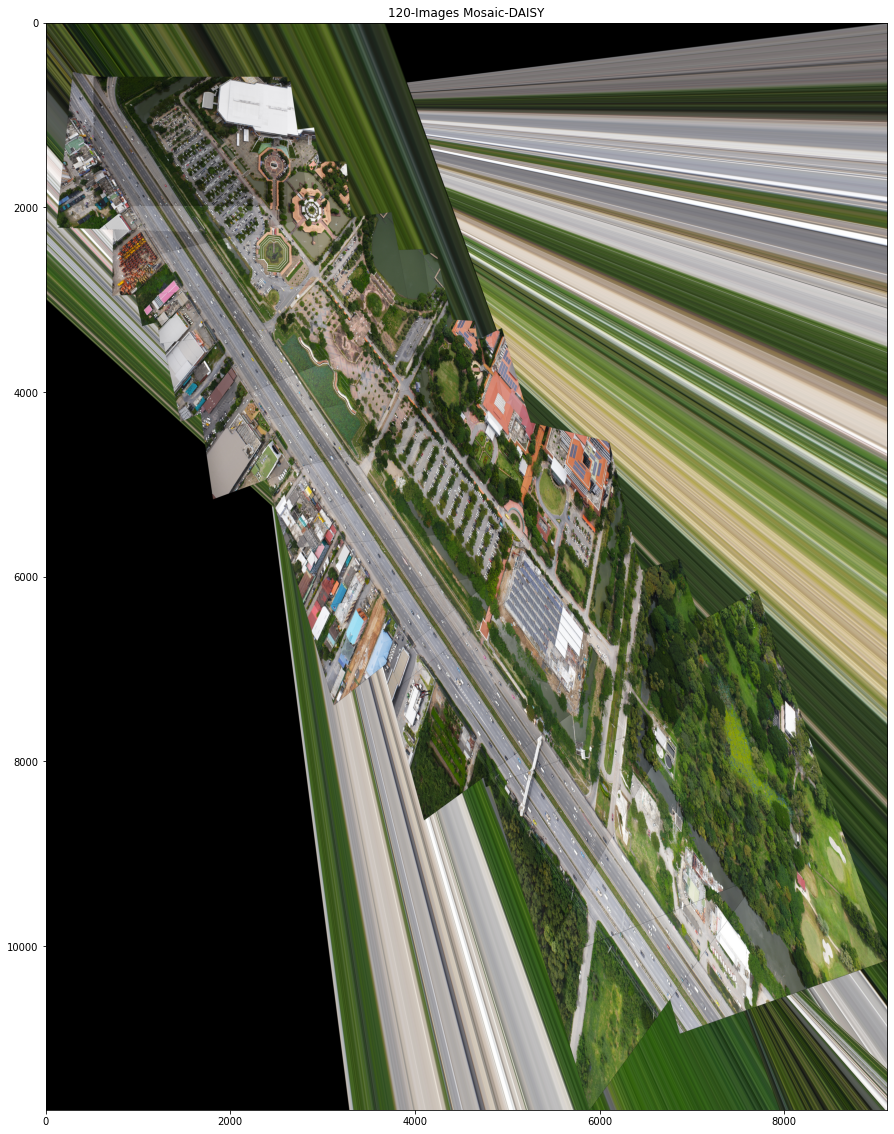

In [40]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_daisy , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-DAISY')

# GFTT 11O Images

In [16]:
gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]
for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = gftt.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_gftt.append(kpt)
    descriptors_all_left_gftt.append(descrip)
    points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = gftt.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_gftt.append(kpt)
    descriptors_all_right_gftt.append(descrip)
    points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [00:12<00:00,  4.83it/s]


In [25]:
num_kps_gftt = []
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt):
  num_kps_gftt.append(len(j))

100%|██████████| 110/110 [00:00<00:00, 176231.26it/s]


In [28]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1])
    H_left_gftt.append(H_a)
    num_matches_gftt.append(matches)
    num_good_matches_gftt.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1])
    H_right_gftt.append(H_a)
    num_matches_gftt.append(matches)
    num_good_matches_gftt.append(gd_matches) 

  6%|▌         | 3/51 [00:00<00:04,  9.88it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 280
Number of Robust matches 230



Number of matches 1000
Number of matches After Lowe's Ratio 75
Number of Robust matches 27



Number of matches 1000
Number of matches After Lowe's Ratio 166
Number of Robust matches 106




 10%|▉         | 5/51 [00:00<00:04, 10.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 235
Number of Robust matches 198



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 254



Number of matches 1000
Number of matches After Lowe's Ratio 316
Number of Robust matches 261




 18%|█▊        | 9/51 [00:00<00:03, 10.98it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 352
Number of Robust matches 284



Number of matches 1000
Number of matches After Lowe's Ratio 381
Number of Robust matches 275



Number of matches 1000
Number of matches After Lowe's Ratio 420
Number of Robust matches 318




 22%|██▏       | 11/51 [00:00<00:03, 11.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 323
Number of Robust matches 224



Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 115



Number of matches 1000
Number of matches After Lowe's Ratio 358
Number of Robust matches 261




 29%|██▉       | 15/51 [00:01<00:03, 11.43it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 192
Number of Robust matches 132



Number of matches 1000
Number of matches After Lowe's Ratio 354
Number of Robust matches 276



Number of matches 1000
Number of matches After Lowe's Ratio 14
Number of Robust matches 5




 33%|███▎      | 17/51 [00:01<00:03, 11.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 53
Number of Robust matches 35



Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 274



Number of matches 1000
Number of matches After Lowe's Ratio 71
Number of Robust matches 30




 41%|████      | 21/51 [00:01<00:02, 11.51it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 50
Number of Robust matches 21



Number of matches 1000
Number of matches After Lowe's Ratio 242
Number of Robust matches 159



Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 88




 45%|████▌     | 23/51 [00:02<00:02, 10.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 30
Number of Robust matches 6



Number of matches 1000
Number of matches After Lowe's Ratio 368
Number of Robust matches 185




 49%|████▉     | 25/51 [00:02<00:02, 10.88it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 395
Number of Robust matches 210



Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 197



Number of matches 1000
Number of matches After Lowe's Ratio 345
Number of Robust matches 192




 57%|█████▋    | 29/51 [00:02<00:01, 11.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 136



Number of matches 1000
Number of matches After Lowe's Ratio 312
Number of Robust matches 142



Number of matches 1000
Number of matches After Lowe's Ratio 267
Number of Robust matches 141




 61%|██████    | 31/51 [00:02<00:02,  9.81it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 277



Number of matches 1000
Number of matches After Lowe's Ratio 399
Number of Robust matches 324




 65%|██████▍   | 33/51 [00:03<00:01, 10.29it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 353
Number of Robust matches 294



Number of matches 1000
Number of matches After Lowe's Ratio 441
Number of Robust matches 357



Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 294




 73%|███████▎  | 37/51 [00:03<00:01, 10.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 392
Number of Robust matches 301



Number of matches 1000
Number of matches After Lowe's Ratio 358
Number of Robust matches 229



Number of matches 1000
Number of matches After Lowe's Ratio 322
Number of Robust matches 188




 76%|███████▋  | 39/51 [00:03<00:01, 10.99it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 296
Number of Robust matches 176



Number of matches 1000
Number of matches After Lowe's Ratio 490
Number of Robust matches 404



Number of matches 1000
Number of matches After Lowe's Ratio 454
Number of Robust matches 338




 84%|████████▍ | 43/51 [00:03<00:00, 11.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 195



Number of matches 1000
Number of matches After Lowe's Ratio 266
Number of Robust matches 182



Number of matches 1000
Number of matches After Lowe's Ratio 369
Number of Robust matches 253




 88%|████████▊ | 45/51 [00:04<00:00, 11.53it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 148



Number of matches 1000
Number of matches After Lowe's Ratio 239
Number of Robust matches 187



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 190




 96%|█████████▌| 49/51 [00:04<00:00, 11.59it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 395
Number of Robust matches 278



Number of matches 1000
Number of matches After Lowe's Ratio 218
Number of Robust matches 105



Number of matches 1000
Number of matches After Lowe's Ratio 354
Number of Robust matches 162




  3%|▎         | 2/59 [00:00<00:04, 12.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 96
Number of Robust matches 24



Number of matches 1000
Number of matches After Lowe's Ratio 208
Number of Robust matches 135



Number of matches 1000
Number of matches After Lowe's Ratio 193
Number of Robust matches 123




  7%|▋         | 4/59 [00:00<00:04, 11.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 79



Number of matches 1000
Number of matches After Lowe's Ratio 212
Number of Robust matches 106



Number of matches 1000
Number of matches After Lowe's Ratio 163
Number of Robust matches 90




 12%|█▏        | 7/59 [00:00<00:05, 10.25it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 296
Number of Robust matches 165



Number of matches 1000
Number of matches After Lowe's Ratio 41
Number of Robust matches 8




 17%|█▋        | 10/59 [00:00<00:04, 10.24it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 88
Number of Robust matches 23



Number of matches 1000
Number of matches After Lowe's Ratio 173
Number of Robust matches 78



Number of matches 1000
Number of matches After Lowe's Ratio 199
Number of Robust matches 86




 20%|██        | 12/59 [00:01<00:04, 10.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 368
Number of Robust matches 280



Number of matches 1000
Number of matches After Lowe's Ratio 387
Number of Robust matches 325



Number of matches 1000
Number of matches After Lowe's Ratio 252
Number of Robust matches 200




 27%|██▋       | 16/59 [00:01<00:03, 10.82it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 109
Number of Robust matches 57



Number of matches 1000
Number of matches After Lowe's Ratio 375
Number of Robust matches 260



Number of matches 1000
Number of matches After Lowe's Ratio 159
Number of Robust matches 111




 31%|███       | 18/59 [00:01<00:03, 10.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 461
Number of Robust matches 426



Number of matches 1000
Number of matches After Lowe's Ratio 451
Number of Robust matches 388



Number of matches 1000
Number of matches After Lowe's Ratio 389
Number of Robust matches 267




 37%|███▋      | 22/59 [00:01<00:03, 11.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 265



Number of matches 1000
Number of matches After Lowe's Ratio 225
Number of Robust matches 160



Number of matches 1000
Number of matches After Lowe's Ratio 360
Number of Robust matches 265




 41%|████      | 24/59 [00:02<00:03, 11.57it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 377
Number of Robust matches 280



Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 297



Number of matches 1000
Number of matches After Lowe's Ratio 310
Number of Robust matches 230




 47%|████▋     | 28/59 [00:02<00:02, 11.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 367
Number of Robust matches 255



Number of matches 1000
Number of matches After Lowe's Ratio 329
Number of Robust matches 221



Number of matches 1000
Number of matches After Lowe's Ratio 371
Number of Robust matches 184




 51%|█████     | 30/59 [00:02<00:02, 11.64it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 199



Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 161



Number of matches 1000
Number of matches After Lowe's Ratio 226
Number of Robust matches 137




 58%|█████▊    | 34/59 [00:03<00:02, 11.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 60
Number of Robust matches 23



Number of matches 1000
Number of matches After Lowe's Ratio 154
Number of Robust matches 91



Number of matches 1000
Number of matches After Lowe's Ratio 19
Number of Robust matches 5




 61%|██████    | 36/59 [00:03<00:02, 11.37it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 133
Number of Robust matches 56



Number of matches 1000
Number of matches After Lowe's Ratio 291
Number of Robust matches 148



Number of matches 1000
Number of matches After Lowe's Ratio 355
Number of Robust matches 191




 68%|██████▊   | 40/59 [00:03<00:01, 11.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 262
Number of Robust matches 132



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 138



Number of matches 1000
Number of matches After Lowe's Ratio 243
Number of Robust matches 67




 71%|███████   | 42/59 [00:03<00:01, 11.20it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 389
Number of Robust matches 188



Number of matches 1000
Number of matches After Lowe's Ratio 216
Number of Robust matches 120



Number of matches 1000
Number of matches After Lowe's Ratio 85
Number of Robust matches 38




 78%|███████▊  | 46/59 [00:04<00:01, 11.16it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 215
Number of Robust matches 101



Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 92



Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 194




 81%|████████▏ | 48/59 [00:04<00:00, 11.19it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 373
Number of Robust matches 340



Number of matches 1000
Number of matches After Lowe's Ratio 345
Number of Robust matches 284



Number of matches 1000
Number of matches After Lowe's Ratio 536
Number of Robust matches 445




 88%|████████▊ | 52/59 [00:04<00:00, 11.72it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 207



Number of matches 1000
Number of matches After Lowe's Ratio 471
Number of Robust matches 360



Number of matches 1000
Number of matches After Lowe's Ratio 197
Number of Robust matches 138




 92%|█████████▏| 54/59 [00:04<00:00, 11.46it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 342
Number of Robust matches 250



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 238



Number of matches 1000
Number of matches After Lowe's Ratio 472
Number of Robust matches 347




 98%|█████████▊| 58/59 [00:05<00:00, 11.27it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 333
Number of Robust matches 280



Number of matches 1000
Number of matches After Lowe's Ratio 446
Number of Robust matches 363



Number of matches 1000
Number of matches After Lowe's Ratio 401
Number of Robust matches 316




In [32]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_gftt,H_right_gftt)

Step1:Done
Step2:Done


In [33]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_gftt,xmax,xmin,ymax,ymin,t,h,w,Ht)

step31:Done


In [34]:
warp_imgs_all_daisy = final_step_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_gftt,xmax,xmin,ymax,ymin,t,h,w,Ht)

step32:Done


Text(0.5, 1.0, '120-Images Mosaic-GFTT')

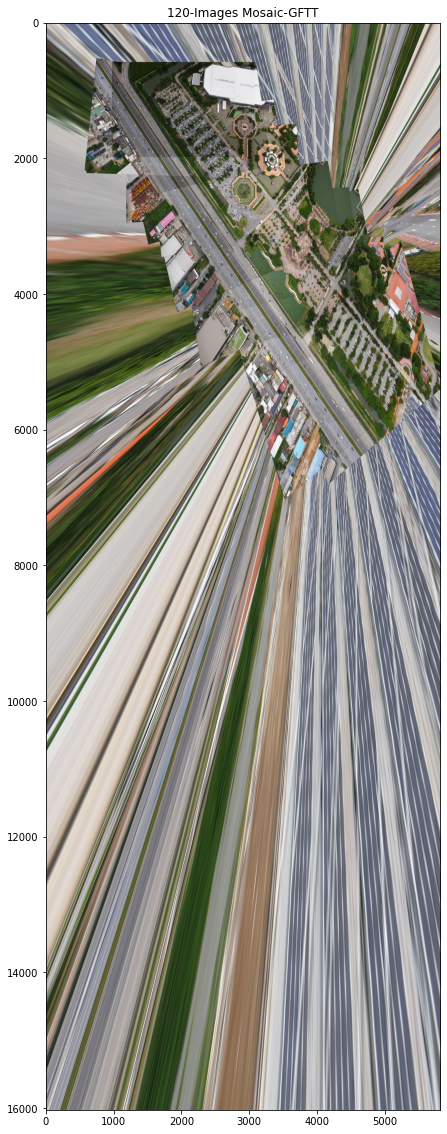

In [35]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_daisy , cv2.COLOR_BGR2RGB))
ax.set_title('120-Images Mosaic-GFTT')

# For AGAST 110 Image

In [10]:
agast = cv2.AgastFeatureDetector_create()
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]


for imgs in tqdm(images_left_bgr_no_enhance):
    kpt = agast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_left_agast.append(kpt)
    descriptors_all_left_agast.append(descrip)
    points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))
    
    
for imgs in tqdm(images_right_bgr_no_enhance):
    kpt = agast.detect(imgs,None)
    kpt,descrip = sift.compute(imgs, kpt)
    keypoints_all_right_agast.append(kpt)
    descriptors_all_right_agast.append(descrip)
    points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 59/59 [07:34<00:00,  7.70s/it]


In [ ]:
num_kps_agast = []
for j in tqdm(keypoints_all_left_agast = keypoints_all_right_agast):
  num_kps_agast.append(len(j))

In [ ]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(images_left))):
    if j==len(images_left)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1])
    H_left_agast.append(H_a)
    num_matches_agast.append(matches)
    num_good_matches_agast.append(gd_matches)
    
for j in tqdm(range(len(images_right))):
    if j==len(images_right)-1:
        break
        
    H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1])
    H_right_agast.append(H_a)
    num_matches_agast.append(matches)
    num_good_matches_agast.append(gd_matches) 